In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config

from toy_models.fit import rescale_run, Pattern, PatternLearningModel
from unifying.sweep import get_history, handle_outliers
from unifying.plotting import BLUE, RED

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")

In [2]:
torch.manual_seed(2)

def plot_patterns(pl_model, run, log=False):
    ts = run["_step"].values
    train_preds = [pl_model(t).detach().numpy() for t in ts]
    test_preds = [pl_model.test(t).detach().numpy() for t in ts]
    train_ys = torch.tensor(run["train/acc"].values).float()
    test_ys = torch.tensor(run["test/acc"].values).float()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(ts, train_preds, label="train", color="blue")
    axes[0].plot(ts, test_preds, label="test", color="red")

    axes[1].plot(ts, train_ys, label="train", color="blue")
    axes[1].plot(ts, test_ys, label="test", color="red")

    axes[0].set_title("Predictions")
    axes[1].set_title("True values")

    if log:
        axes[0].set_xscale("log")
        axes[1].set_xscale("log")

In [125]:
from unifying.sweep import METRICS

def get_history(
    *sweep_ids,
    unique_cols: Union[List[str], str] = "weight_decay",
    entity: str = "jqhoogland",
    project: str = "grokking",
    allow_duplicates=False,
    combine_seeds=False,
):
    """
    Gathers all the runs from a series of sweeps and combines them into a single dataframe.

    `unique_col` is used to identify duplicate runs. By default, `"_step"` is added.
    If there are duplicates, the run from the last sweep is kept.
    """
    api = wandb.Api()
    unique_cols = unique_cols if isinstance(unique_cols, list) else [unique_cols]

    def _get_history(sweep_id):
        """Get a dataframe for a single sweep."""
        sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
        runs = sweep.runs

        def create_run_df(history, config):
            for k, v in config.items():
                if k == "momentum" and isinstance(v, list):
                    v = [tuple(v)] * len(history)
                history[k] = v

            return history

        return pd.concat([create_run_df(run.history(), run.config) for run in runs])

    histories = pd.concat([_get_history(sweep_id) for sweep_id in sweep_ids])

    if not allow_duplicates:
        histories = histories.drop_duplicates(["_step", *unique_cols], keep="last")

    # Change step 0 to 1 to avoid issues with log plots
    histories.loc[histories._step == 0, "_step"] = 1

    # Fix types
    histories.applymap(lambda x: x.item() if isinstance(x, np.generic) else x)
    non_numeric_columns = histories.select_dtypes(
        exclude=["int", "float", "int64", "float64"]
    ).columns
    histories = histories.drop(columns=non_numeric_columns)

    # Sort
    histories = histories.sort_values(by=[*unique_cols, "_step"])

    # Remove any runs that didn't have any steps after 1000
    for unique_col in unique_cols:
        valid_runs = histories.groupby(unique_col).apply(
            lambda x: x["_step"].max() > 1000
        )
        histories = histories[histories[unique_col].isin(valid_runs[valid_runs].index)]

    if combine_seeds:
        assert (
            len(unique_cols) == 1
        ), "Can only combine seeds if there is a single unique column"

        unique_col = unique_cols[0]
        unique_vals = histories[unique_col].unique()

        for val in unique_vals:
            runs = histories[histories[unique_col] == val]
            seeds = runs.seed.unique()

            if len(seeds) > 1:
                # Define the metrics that need to be averaged
                metrics = METRICS
                for metric in metrics:
                    # Calculate the mean value for each metric and _step
                    means_groups = runs.groupby("_step")[metric]

                    means = means_groups.apply(
                        lambda x: x.ffill().bfill().mean() if x.isna().any() else x
                    )

                    # Update the histories dataframe
                    for _step, mean_value in means.items():
                        mask = (histories[unique_col] == val) & (
                            histories._step == _step
                        )
                        histories.loc[mask, metric] = mean_value

        # Remove duplicate rows
        histories = histories.drop_duplicates(subset=[*unique_cols, "_step"])

    return histories

In [126]:
INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd"] #, "awxzpem1"]
interp_sweep = get_history(*INTERP_SWEEPS, project="mnist-grokking", allow_duplicates=True, combine_seeds=True)
# interp_sweep.drop(["weight/cos_sim_with_init", "test/efficiency", "train/efficiency", "weight/dist_from_init"])
interp_sweep

,_step,test/acc,train/acc,weight/cos_sim_with_init,_timestamp,test/efficiency,weight/dist_from_init,test/loss,train/loss,_runtime,...,num_classes,log_interval,weight_decay,frac_label_noise,num_training_steps,test_acc_criterion,corrupted/acc,corrupted/loss,uncorrupted/loss,uncorrupted/acc
0,1,0.143713,0.123752,1.000000,1.684007e+09,138.675528,0.000000,10201.696856,10332.297331,1.853630,...,10,10,0.01,0.1,500000,1,0.076613,NaN,NaN,0.119021
2,2,0.155689,0.123752,1.000000,1.684003e+09,137.734258,0.002599,10132.447605,10261.924670,1.933748,...,10,10,0.01,0.1,500000,1,0.069556,NaN,NaN,0.121014
3,3,0.071856,0.062874,NaN,1.684110e+09,NaN,NaN,4234.938997,4172.454091,1.835384,...,10,10,0.01,0.1,500000,1,0.067204,NaN,NaN,0.124336
4,4,0.083832,0.074850,0.999969,1.684026e+09,27.568225,0.579633,2027.962762,2150.769845,1.864989,...,10,10,0.01,0.1,500000,1,0.100358,NaN,NaN,0.111111
5,5,0.125749,0.100798,0.999984,1.684012e+09,45.310715,0.412972,3333.154192,3458.368064,2.085465,...,10,10,0.01,0.1,500000,1,0.106183,NaN,NaN,0.106302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,499500,0.143713,1.000000,0.995590,1.684057e+09,0.413553,7.258754,29.358591,0.000345,4493.158051,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
158,499700,0.107784,1.000000,0.997127,1.684007e+09,0.679525,5.573177,49.896286,0.000257,4833.025646,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
338,499800,0.502994,1.000000,0.950879,1.684044e+09,0.013117,23.470110,0.843076,0.000297,4486.524069,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
404,499900,0.149701,1.000000,0.995589,1.684057e+09,0.413519,7.259769,29.355416,0.000356,4496.706427,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN


In [127]:
# Filter where corrupted/acc is not NaN
interp_sweep[interp_sweep["corrupted/acc"].notna()].lr_factor.unique()

array([6.   , 1.   , 5.625, 4.   , 3.5  , 5.5  , 7.   , 5.125, 2.   ,
       6.625, 6.375, 1.5  , 1.75 , 6.25 , 6.875, 3.   , 5.   , 4.5  ,
       1.25 , 2.5  , 6.5  , 5.875, 5.75 , 4.875, 6.125, 5.375, 4.25 ,
       4.625, 4.75 , 6.75 , 5.25 ])

In [159]:
from scipy.ndimage import gaussian_filter
from unifying.sweep import get_pivot

# Get pivot_table
df = get_pivot(interp_sweep, "lr_factor", METRICS, reindex=True, interpolate=True) 
unique_vals = sorted(interp_sweep["lr_factor"].unique())

# for m in METRICS:
#     _df = gaussian_filter(df[m], sigma=(5., 1.))
# 
#     for i, unique_val in enumerate(unique_vals):
#         df[(m, unique_val)] = _df[:, i]

In [160]:
# df = df_filtered.reindex(np.arange(df_filtered._step.min(), df_filtered._step.max() + 1))
# df = df.interpolate(method="linear", axis=0, inplace=True).fillna(method="bfill")
LR_FACTOR = 5.
run = df[[col for col in df.columns if col[1] == LR_FACTOR]]
# run = interp_sweep.loc[interp_sweep.lr_factor == LR_FACTOR, :]
# steps = sorted(run.index.unique())
# run = run[steps, :]
# Convert back to non-pivot
run = pd.DataFrame(run.stack().reset_index())
run

,_step,lr_factor,corrupted/acc,test/acc,test/loss,train/acc,train/loss,uncorrupted/acc
0,1,5.0,0.109238,0.125749,467.193815,0.063872,461.849971,0.112239
1,2,5.0,0.109238,0.125749,467.193815,0.063872,461.849971,0.112239
2,3,5.0,0.109238,0.125749,467.193815,0.063872,461.849971,0.112239
3,4,5.0,0.109238,0.125749,467.193815,0.063872,461.849971,0.112239
4,5,5.0,0.109238,0.125749,467.193815,0.063872,461.849971,0.112239
...,...,...,...,...,...,...,...,...
499993,499994,5.0,0.998992,0.491018,0.908397,1.000000,0.000430,0.998434
499994,499995,5.0,0.998992,0.491018,0.908397,1.000000,0.000430,0.998434
499995,499996,5.0,0.998992,0.491018,0.908397,1.000000,0.000430,0.998434
499996,499997,5.0,0.998992,0.491018,0.908397,1.000000,0.000430,0.998434


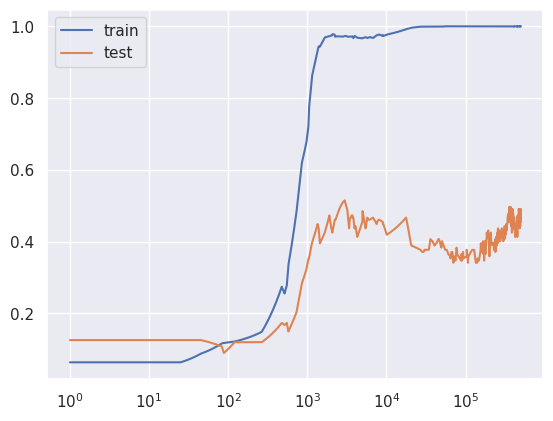

In [161]:
plt.plot(run._step, run["train/acc"], label="train")
# plt.plot(run.index, run["train/acc"], label="smoothed")
plt.plot(run._step, run["test/acc"], label="test")
# plt.plot(run.index, run["test/acc"], label="smoothed")
plt.xscale("log")
plt.legend()
plt.show()

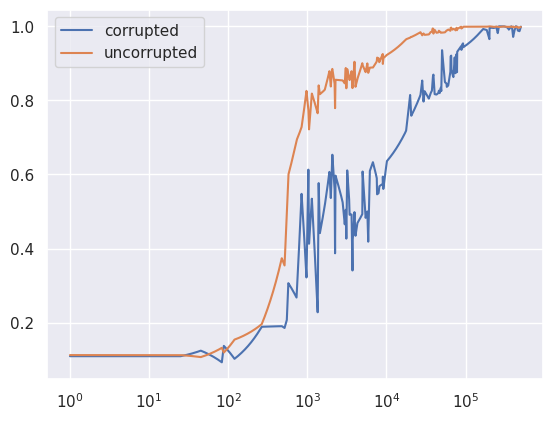

In [162]:
plt.plot(run._step, run["corrupted/acc"], label="corrupted")
# plt.plot(run.index, run["train/acc"], label="smoothed")
plt.plot(run._step, run["uncorrupted/acc"], label="uncorrupted")
# plt.plot(run.index, run["test/acc"], label="smoothed")
plt.xscale("log")
plt.legend()
plt.show()

<Axes: xlabel='_step'>

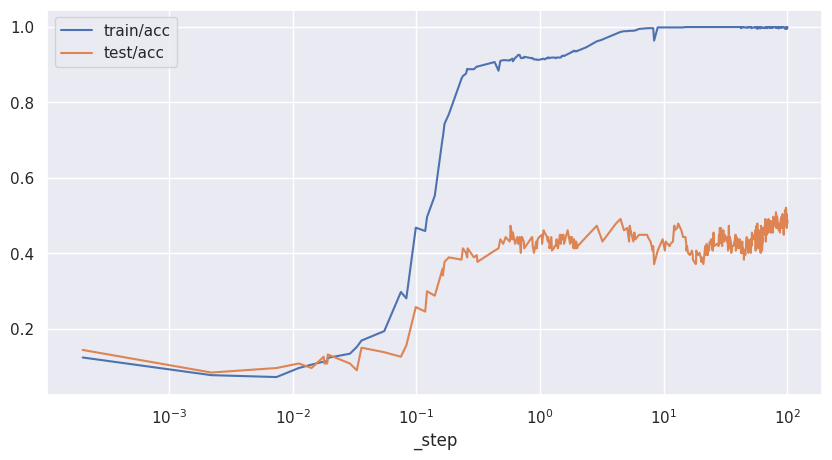

In [122]:
rescaled_run = rescale_run(run, new_max=100., log=False) 
rescaled_run.plot(x="_step", y=["train/acc", "test/acc"], logx=True, figsize=(10, 5))

/home/jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ModuleList(
  (0): Pattern(strength=0.5, speed=50.0, onset=0.10000000149011612, generalization=0.5)
  (1): Pattern(strength=0.5, speed=5.0, onset=1.778279423713684, generalization=0.5)
  (2): Pattern(strength=0.5, speed=0.5, onset=31.62277603149414, generalization=0.5)
)


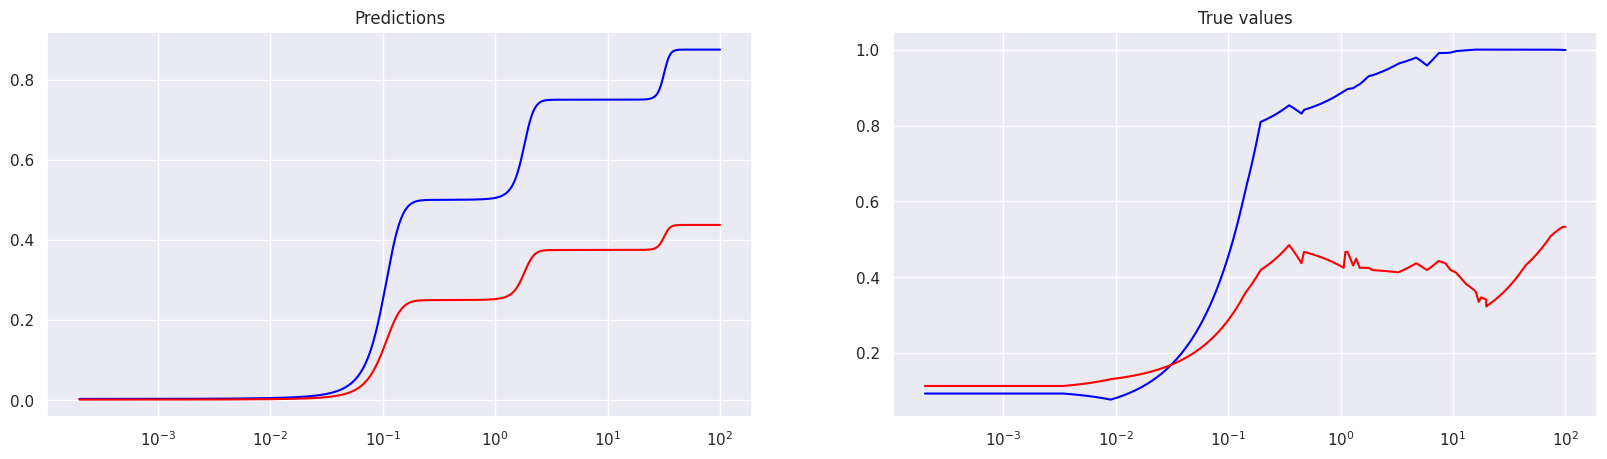

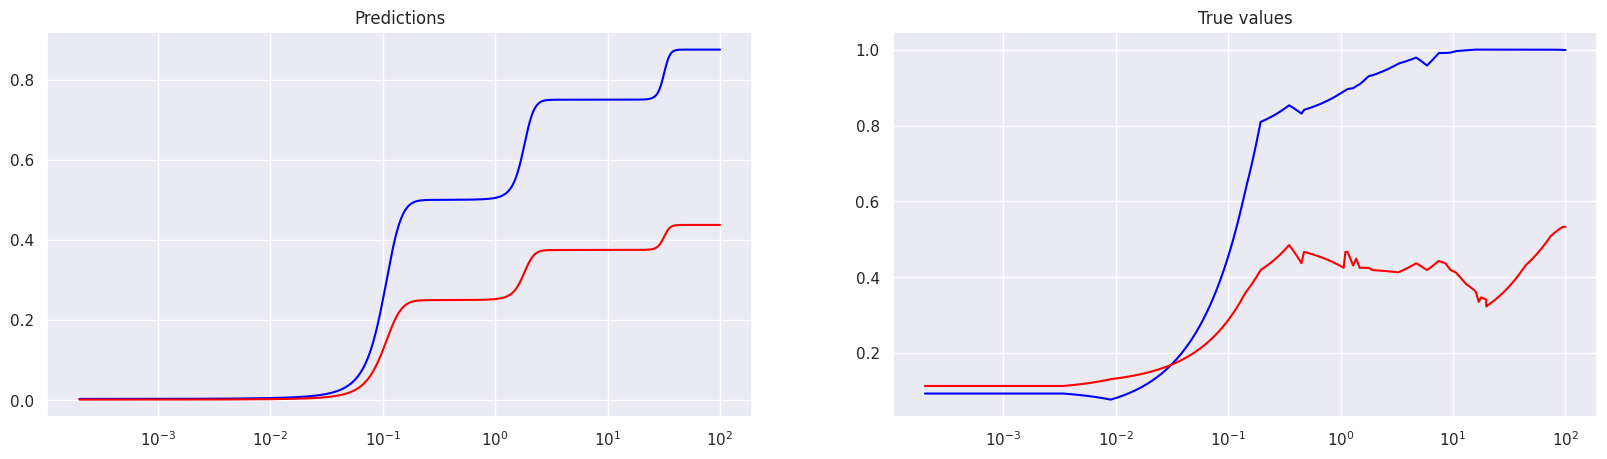

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.05686461552977562


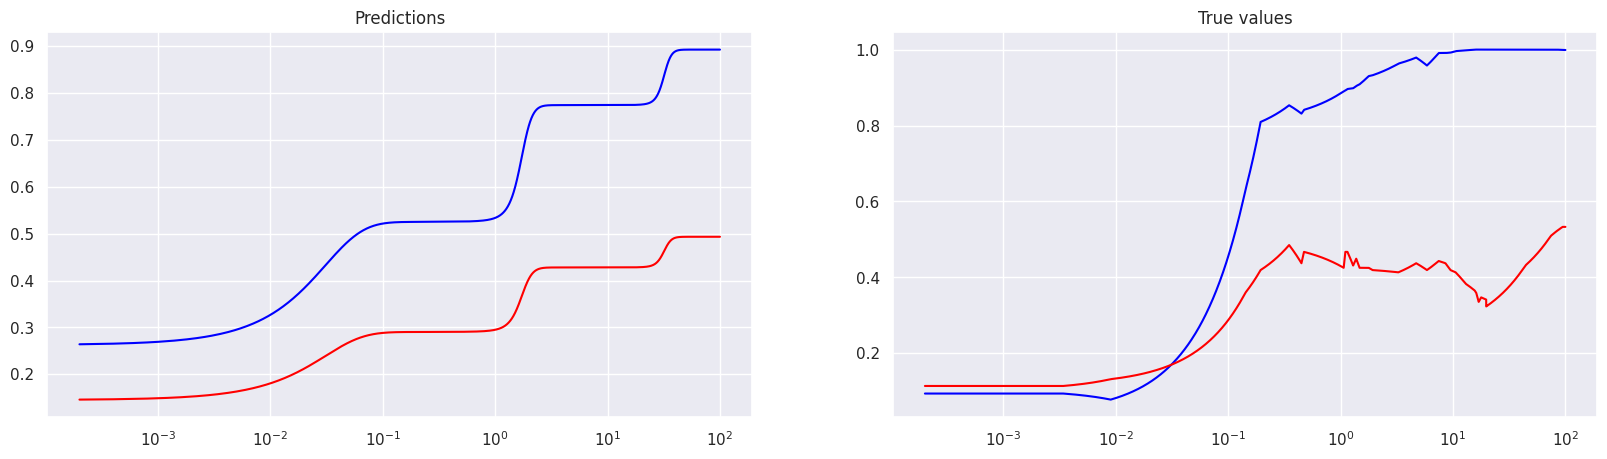

Epoch 1 - loss: 0.04428505897521973
Epoch 2 - loss: 0.03546804189682007
Epoch 3 - loss: 0.028004901483654976
Epoch 4 - loss: 0.021729789674282074
Epoch 5 - loss: 0.014278609305620193
Epoch 6 - loss: 0.013678260147571564
Epoch 7 - loss: 0.009362775832414627
Epoch 8 - loss: 0.008126149885356426
Epoch 9 - loss: 0.007910934276878834
Epoch 10 - loss: 0.006567640230059624
Epoch 11 - loss: 0.005398455075919628
Epoch 12 - loss: 0.005143128335475922
Epoch 13 - loss: 0.005155620630830526
Epoch 14 - loss: 0.0046830023638904095
Epoch 15 - loss: 0.004126174375414848
Epoch 16 - loss: 0.0039325738325715065
Epoch 17 - loss: 0.0039622606709599495
Epoch 18 - loss: 0.0038240074645727873
Epoch 19 - loss: 0.003522487822920084
Epoch 20 - loss: 0.003361028153449297
Epoch 21 - loss: 0.003480506595224142
Epoch 22 - loss: 0.003683071583509445
Epoch 23 - loss: 0.003722432069480419
Epoch 24 - loss: 0.0036290124990046024
Epoch 25 - loss: 0.003603937802836299


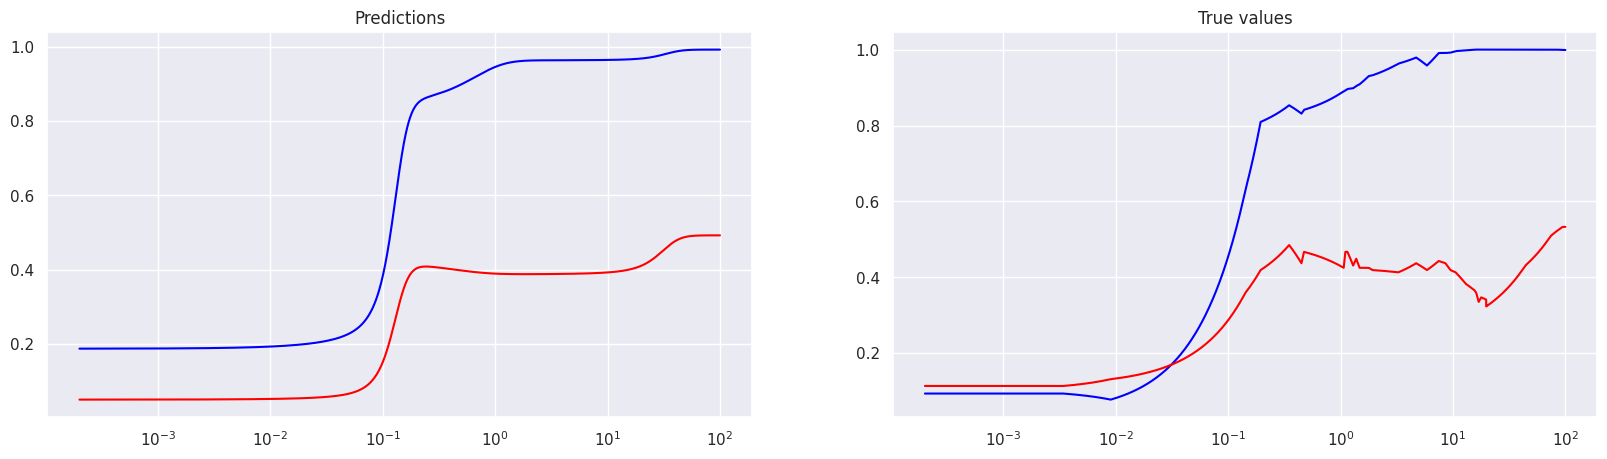

Epoch 26 - loss: 0.003710567019879818
Epoch 27 - loss: 0.003805124433711171
Epoch 28 - loss: 0.0037457195576280355
Epoch 29 - loss: 0.0035702092573046684
Epoch 30 - loss: 0.00343326642177999
Epoch 31 - loss: 0.003401657333597541
Epoch 32 - loss: 0.0033793230541050434
Epoch 33 - loss: 0.0032768454402685165
Epoch 34 - loss: 0.0031539243645966053
Epoch 35 - loss: 0.0031075954902917147
Epoch 36 - loss: 0.003116701263934374
Epoch 37 - loss: 0.0030947981867939234
Epoch 38 - loss: 0.003036120440810919
Epoch 39 - loss: 0.0030026582535356283
Epoch 40 - loss: 0.002997038420289755
Epoch 41 - loss: 0.0029601282440125942
Epoch 42 - loss: 0.0028880443423986435
Epoch 43 - loss: 0.0028357983101159334
Epoch 44 - loss: 0.002810418838635087
Epoch 45 - loss: 0.002765438286587596
Epoch 46 - loss: 0.0026956412475556135
Epoch 47 - loss: 0.0026457728818058968
Epoch 48 - loss: 0.002625382039695978
Epoch 49 - loss: 0.0025956626050174236
Epoch 50 - loss: 0.0025441902689635754


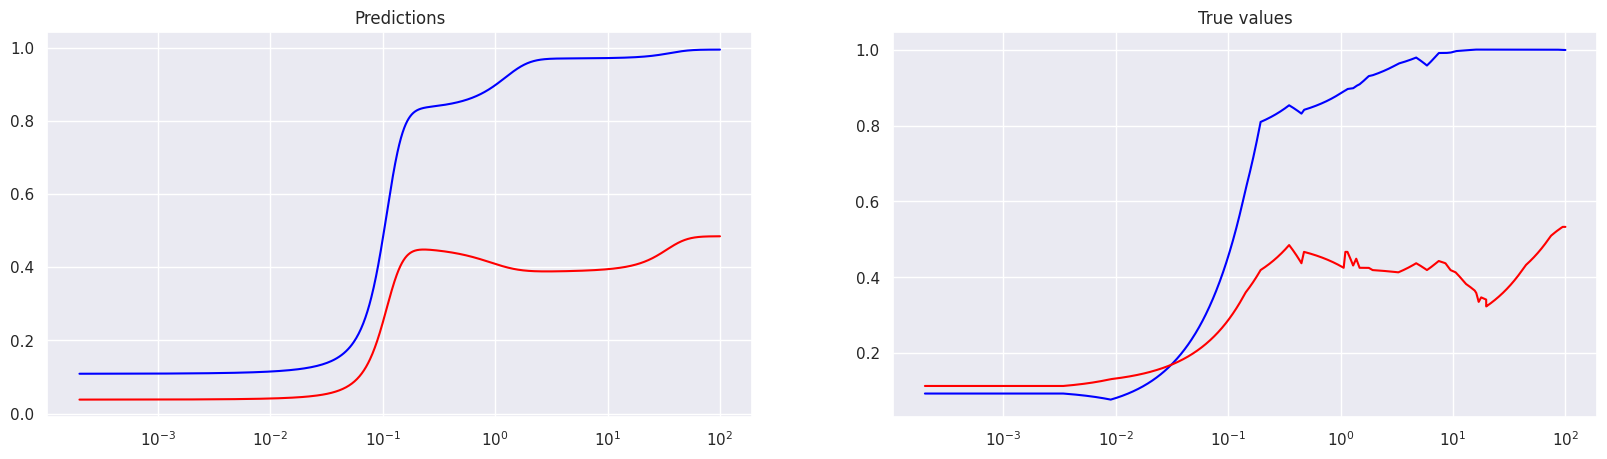

Epoch 51 - loss: 0.002497035078704357
Epoch 52 - loss: 0.0024579279124736786
Epoch 53 - loss: 0.0024035153910517693
Epoch 54 - loss: 0.00233440357260406
Epoch 55 - loss: 0.0022784406319260597
Epoch 56 - loss: 0.0022486881352961063
Epoch 57 - loss: 0.002225529868155718
Epoch 58 - loss: 0.00219135545194149
Epoch 59 - loss: 0.002177155576646328
Epoch 60 - loss: 0.002150424290448427
Epoch 61 - loss: 0.0020699494052678347
Epoch 62 - loss: 0.0020144626032561064
Epoch 63 - loss: 0.001996852457523346
Epoch 64 - loss: 0.0019676685333251953
Epoch 65 - loss: 0.0019398874137550592
Epoch 66 - loss: 0.0018990321550518274
Epoch 67 - loss: 0.0018416267121210694
Epoch 68 - loss: 0.001836875337176025
Epoch 69 - loss: 0.0018039130372926593
Epoch 70 - loss: 0.0017902131658047438
Epoch 71 - loss: 0.001753858639858663
Epoch 72 - loss: 0.0017291535623371601
Epoch 73 - loss: 0.001716122031211853
Epoch 74 - loss: 0.001702682115137577
Epoch 75 - loss: 0.001688796328380704


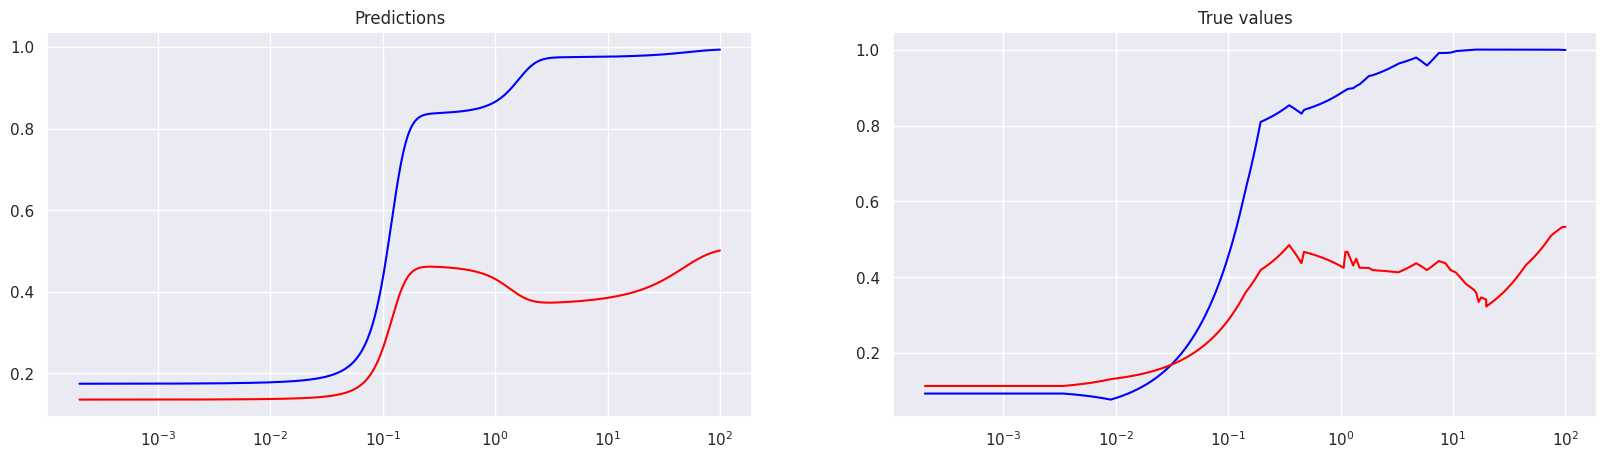

Epoch 76 - loss: 0.001664247247390449
Epoch 77 - loss: 0.001656439621001482
Epoch 78 - loss: 0.0016482154605910182
Epoch 79 - loss: 0.0016359224682673812
Epoch 80 - loss: 0.0016292044892907143
Epoch 81 - loss: 0.001609278260730207
Epoch 82 - loss: 0.0016109836287796497
Epoch 83 - loss: 0.001598543836735189
Epoch 84 - loss: 0.0015931252855807543
Epoch 85 - loss: 0.0015832576900720596
Epoch 86 - loss: 0.0015744217671453953
Epoch 87 - loss: 0.001574819441884756
Epoch 88 - loss: 0.0015627600951120257
Epoch 89 - loss: 0.0015547492075711489
Epoch 90 - loss: 0.0015518054133281112
Epoch 91 - loss: 0.0015427026664838195
Epoch 92 - loss: 0.0015378909884020686
Epoch 93 - loss: 0.0015311555471271276
Epoch 94 - loss: 0.0015227347612380981
Epoch 95 - loss: 0.0015194809529930353
Epoch 96 - loss: 0.0015133654233068228
Epoch 97 - loss: 0.0015050676884129643
Epoch 98 - loss: 0.0015006172470748425
Epoch 99 - loss: 0.0014956670347601175
Epoch 100 - loss: 0.0014888675650581717


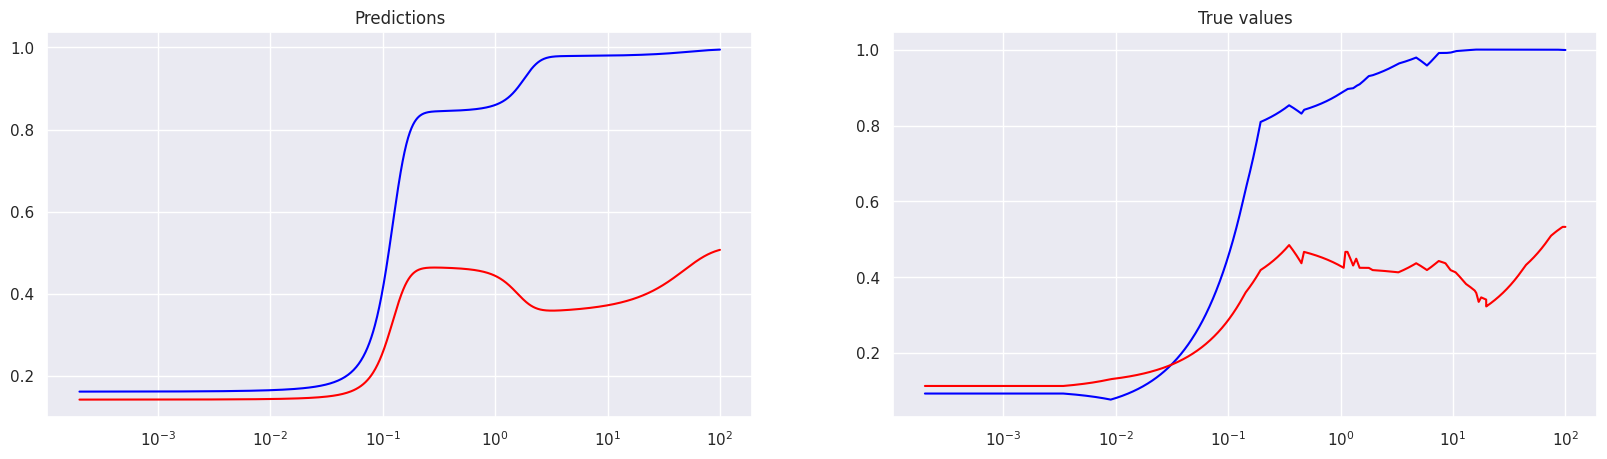

Epoch 101 - loss: 0.0014837109483778477
Epoch 102 - loss: 0.0014787075342610478
Epoch 103 - loss: 0.0014730370603501797
Epoch 104 - loss: 0.0014681107131764293
Epoch 105 - loss: 0.001463260967284441
Epoch 106 - loss: 0.0014579702401533723
Epoch 107 - loss: 0.0014533351641148329
Epoch 108 - loss: 0.0014490288449451327
Epoch 109 - loss: 0.0014441035455092788
Epoch 110 - loss: 0.0014394385507330298
Epoch 111 - loss: 0.0014355239691212773
Epoch 112 - loss: 0.0014313184656202793
Epoch 113 - loss: 0.001426725648343563
Epoch 114 - loss: 0.0014227116480469704
Epoch 115 - loss: 0.0014190338551998138
Epoch 116 - loss: 0.0014149469789117575
Epoch 117 - loss: 0.0014108647592365742
Epoch 118 - loss: 0.001407251344062388
Epoch 119 - loss: 0.0014036954380571842
Epoch 120 - loss: 0.0013998933136463165
Epoch 121 - loss: 0.0013961732620373368
Epoch 122 - loss: 0.0013927516993135214
Epoch 123 - loss: 0.001389344921335578
Epoch 124 - loss: 0.0013858003076165915
Epoch 125 - loss: 0.0013823382323607802


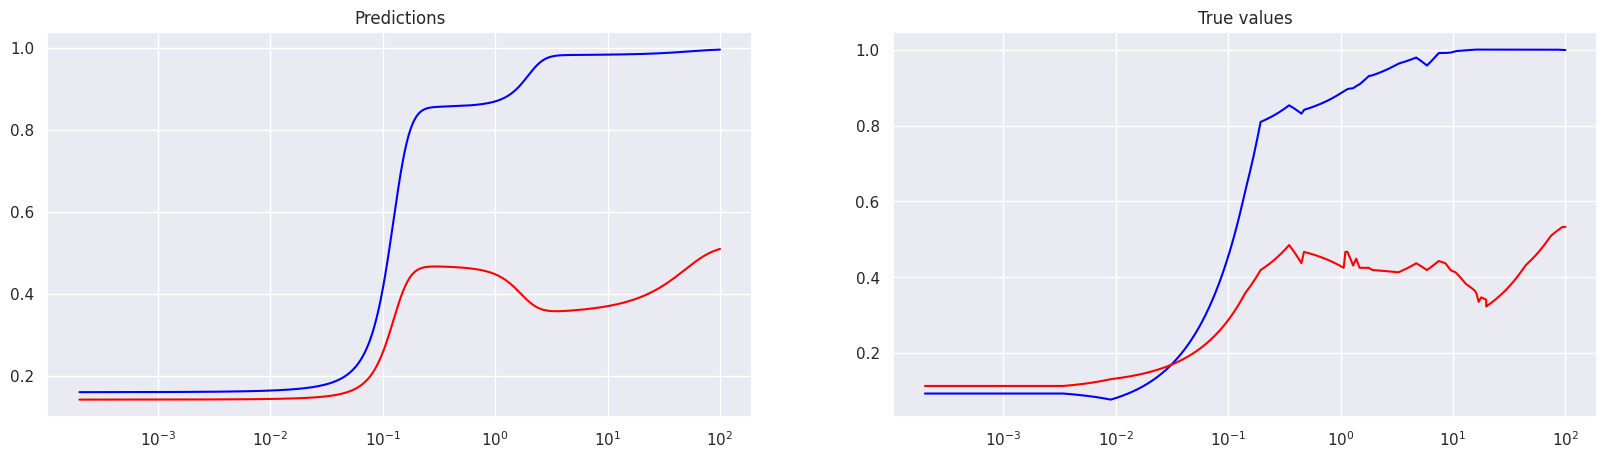

Epoch 126 - loss: 0.001379044959321618
Epoch 127 - loss: 0.001375779276713729
Epoch 128 - loss: 0.0013724747113883495
Epoch 129 - loss: 0.0013691928470507264
Epoch 130 - loss: 0.0013659847900271416
Epoch 131 - loss: 0.0013628399465233088
Epoch 132 - loss: 0.0013597244396805763
Epoch 133 - loss: 0.0013566062552854419
Epoch 134 - loss: 0.001353487721644342
Epoch 135 - loss: 0.0013504269300028682
Epoch 136 - loss: 0.0013474399456754327
Epoch 137 - loss: 0.001344468561001122
Epoch 138 - loss: 0.0013414795976132154
Epoch 139 - loss: 0.0013385092606768012
Epoch 140 - loss: 0.0013355894479900599
Epoch 141 - loss: 0.0013327058404684067
Epoch 142 - loss: 0.0013298450503498316
Epoch 143 - loss: 0.0013270053314045072
Epoch 144 - loss: 0.0013241765554994345
Epoch 145 - loss: 0.001321356394328177
Epoch 146 - loss: 0.001318562077358365
Epoch 147 - loss: 0.0013158011715859175
Epoch 148 - loss: 0.0013130645966157317
Epoch 149 - loss: 0.0013103478122502565
Epoch 150 - loss: 0.0013076512841507792


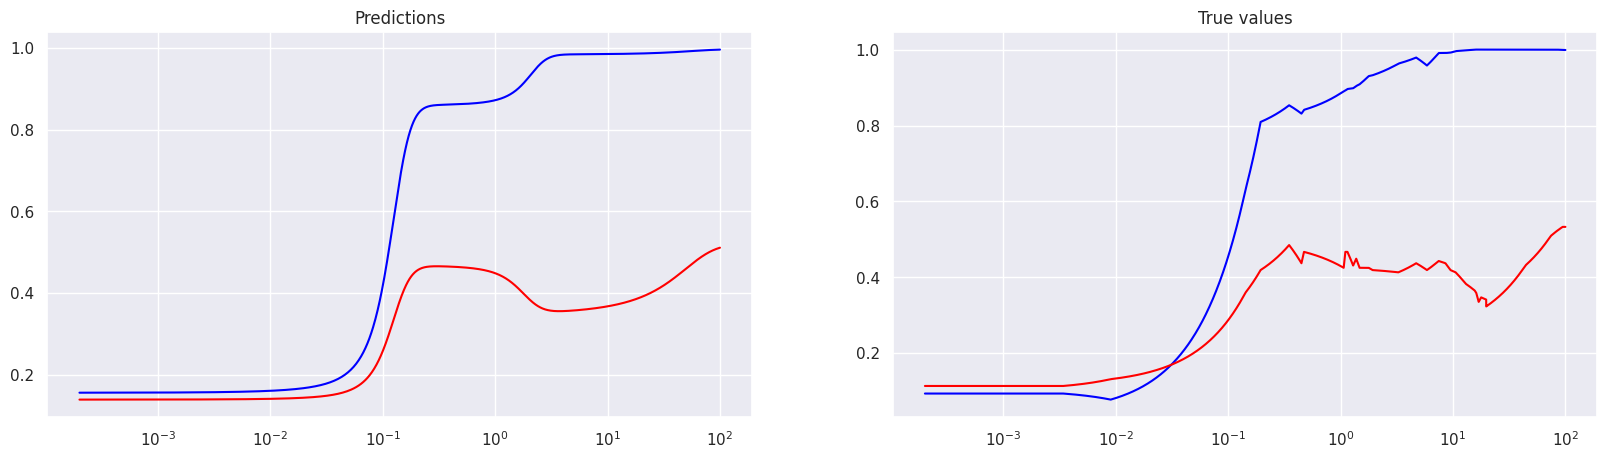

Epoch 151 - loss: 0.0013049701228737831
Epoch 152 - loss: 0.0013023015344515443
Epoch 153 - loss: 0.0012996478471904993
Epoch 154 - loss: 0.0012970129027962685
Epoch 155 - loss: 0.0012943933252245188
Epoch 156 - loss: 0.001291789929382503
Epoch 157 - loss: 0.0012892044615000486
Epoch 158 - loss: 0.0012866354081779718
Epoch 159 - loss: 0.001284081139601767
Epoch 160 - loss: 0.0012815429363399744
Epoch 161 - loss: 0.0012790203327313066
Epoch 162 - loss: 0.0012765128631144762
Epoch 163 - loss: 0.0012740211095660925
Epoch 164 - loss: 0.0012715487973764539
Epoch 165 - loss: 0.0012690969742834568
Epoch 166 - loss: 0.0012666769325733185
Epoch 167 - loss: 0.0012643066002056003
Epoch 168 - loss: 0.001262038596905768
Epoch 169 - loss: 0.0012599602341651917
Epoch 170 - loss: 0.0012583914212882519
Epoch 171 - loss: 0.001257726107724011
Epoch 172 - loss: 0.0012601502239704132
Epoch 173 - loss: 0.0012664454989135265
Epoch 174 - loss: 0.0012927179923281074
Epoch 175 - loss: 0.001316221896559


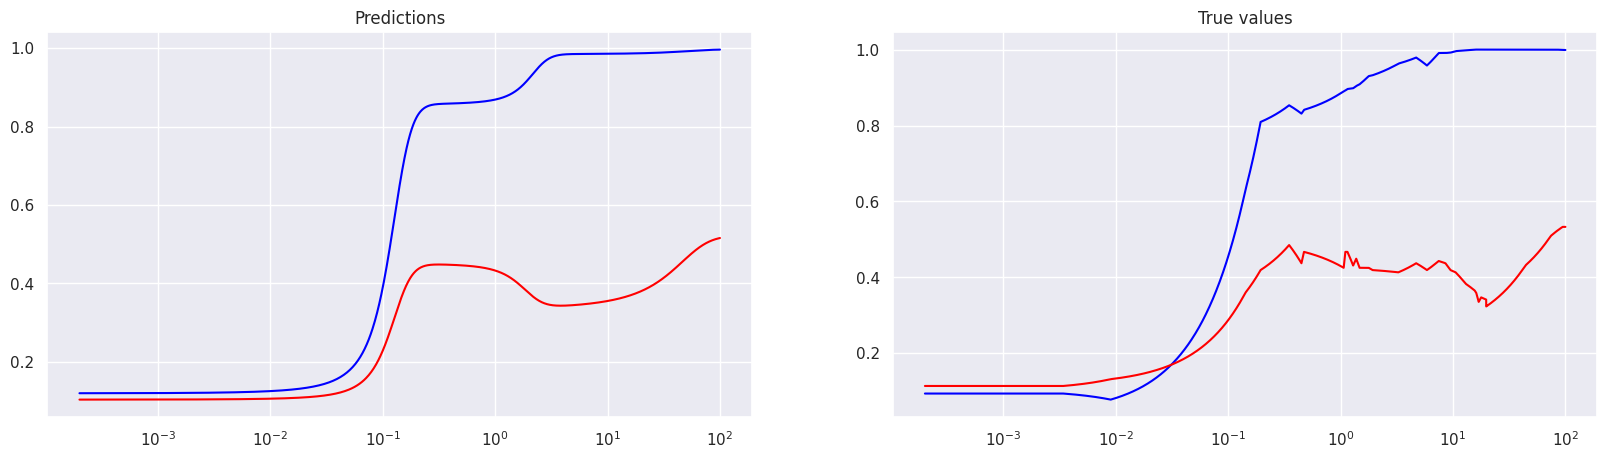

Epoch 176 - loss: 0.00142403575591743
Epoch 177 - loss: 0.001328781247138977
Epoch 178 - loss: 0.0012954508420079947
Epoch 179 - loss: 0.0012408682378008962
Epoch 180 - loss: 0.001250019995495677
Epoch 181 - loss: 0.0013086976250633597
Epoch 182 - loss: 0.0012982274638488889
Epoch 183 - loss: 0.001295410911552608
Epoch 184 - loss: 0.0012368933530524373
Epoch 185 - loss: 0.001252924557775259
Epoch 186 - loss: 0.0013134292094036937
Epoch 187 - loss: 0.0012549927923828363
Epoch 188 - loss: 0.0012213928857818246
Epoch 189 - loss: 0.0012251394800841808
Epoch 190 - loss: 0.001242802944034338
Epoch 191 - loss: 0.0012523011537268758
Epoch 192 - loss: 0.0012177202152088284
Epoch 193 - loss: 0.0012076464481651783
Epoch 194 - loss: 0.0012231409782543778
Epoch 195 - loss: 0.0012338623637333512
Epoch 196 - loss: 0.0012488083448261023
Epoch 197 - loss: 0.001218663644976914
Epoch 198 - loss: 0.0011997271794825792
Epoch 199 - loss: 0.0011941646225750446
Epoch 200 - loss: 0.0012041733134537935


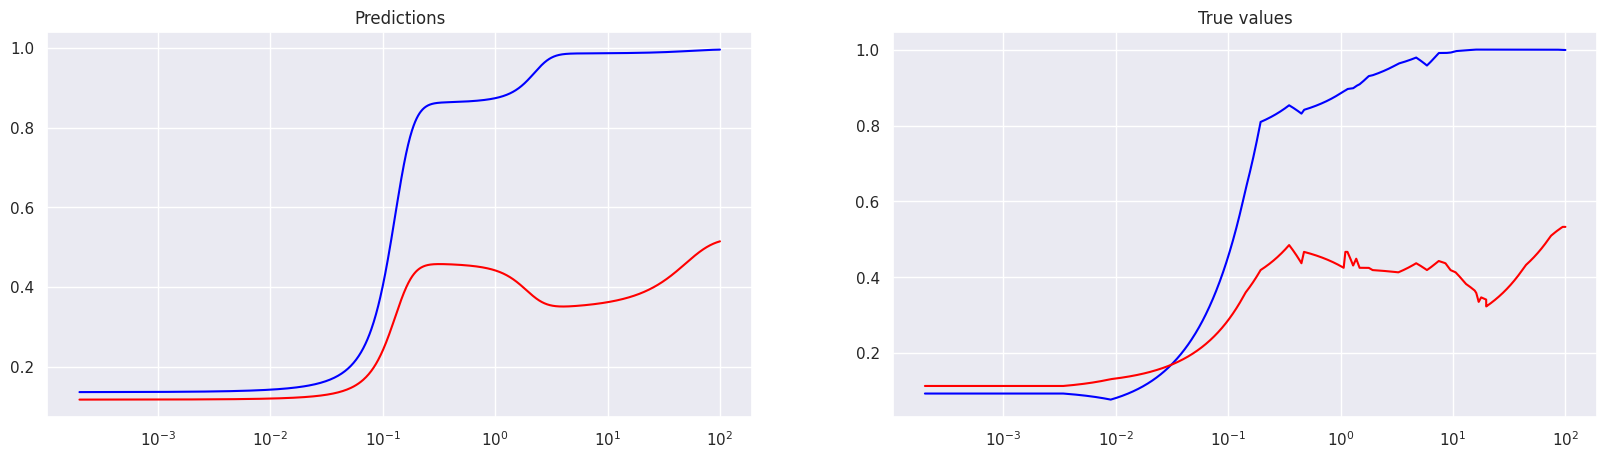

Epoch 201 - loss: 0.0012264181859791279
Epoch 202 - loss: 0.0012268656864762306
Epoch 203 - loss: 0.0012396500678732991
Epoch 204 - loss: 0.0012036653934046626
Epoch 205 - loss: 0.0011827033013105392
Epoch 206 - loss: 0.001181985018774867
Epoch 207 - loss: 0.0011965925805270672
Epoch 208 - loss: 0.001221957616508007
Epoch 209 - loss: 0.0012094283010810614
Epoch 210 - loss: 0.001200681203044951
Epoch 211 - loss: 0.0011735039297491312
Epoch 212 - loss: 0.0011716458247974515
Epoch 213 - loss: 0.0011934167705476284
Epoch 214 - loss: 0.0011998508125543594
Epoch 215 - loss: 0.0012104895431548357
Epoch 216 - loss: 0.0011772444704547524
Epoch 217 - loss: 0.001159770181402564
Epoch 218 - loss: 0.0011638058349490166
Epoch 219 - loss: 0.0011786676477640867
Epoch 220 - loss: 0.001200017286464572
Epoch 221 - loss: 0.001179190818220377
Epoch 222 - loss: 0.001166059635579586
Epoch 223 - loss: 0.0011485094437375665
Epoch 224 - loss: 0.0011489130556583405
Epoch 225 - loss: 0.0011659546289592981


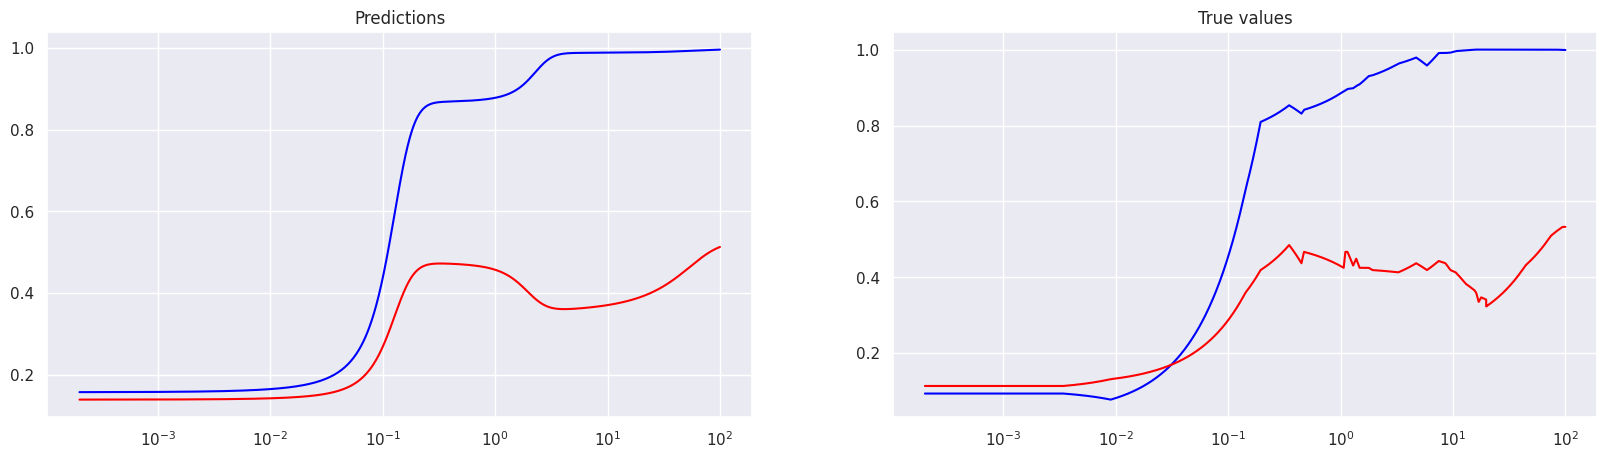

Epoch 226 - loss: 0.0011715501314029098
Epoch 227 - loss: 0.0011834129691123962
Epoch 228 - loss: 0.0011584815802052617
Epoch 229 - loss: 0.001140922773629427
Epoch 230 - loss: 0.001133659272454679
Epoch 231 - loss: 0.0011435241904109716
Epoch 232 - loss: 0.0011629656655713916
Epoch 233 - loss: 0.0011595579562708735
Epoch 234 - loss: 0.0011613834649324417
Epoch 235 - loss: 0.0011347692925482988
Epoch 236 - loss: 0.0011229905067011714
Epoch 237 - loss: 0.0011323646176606417
Epoch 238 - loss: 0.0011445929994806647
Epoch 239 - loss: 0.0011608786880970001
Epoch 240 - loss: 0.0011395304463803768
Epoch 241 - loss: 0.0011226836359128356
Epoch 242 - loss: 0.0011130277998745441
Epoch 243 - loss: 0.0011226015631109476
Epoch 244 - loss: 0.001141757471486926
Epoch 245 - loss: 0.0011347689433023334
Epoch 246 - loss: 0.0011300980113446712
Epoch 247 - loss: 0.0011099034454673529
Epoch 248 - loss: 0.0011042392579838634
Epoch 249 - loss: 0.0011159373680129647
Epoch 250 - loss: 0.0011230050586163998


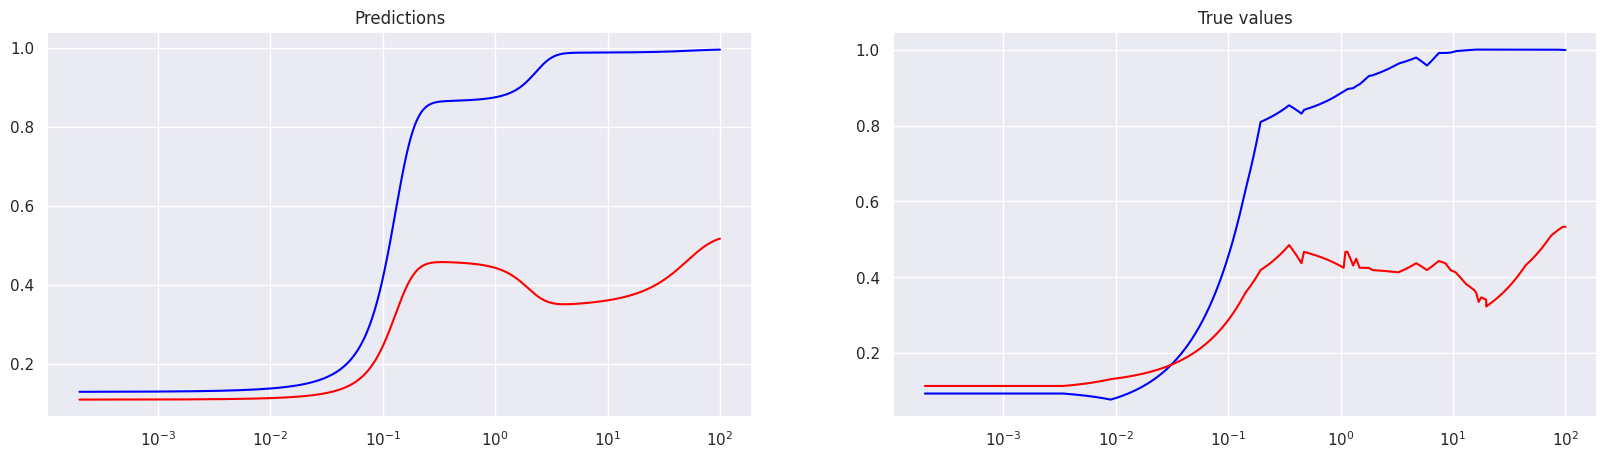

Epoch 251 - loss: 0.0011306453961879015
Epoch 252 - loss: 0.0011120388517156243
Epoch 253 - loss: 0.0010984750697389245
Epoch 254 - loss: 0.0010936073958873749
Epoch 255 - loss: 0.0011017284123227
Epoch 256 - loss: 0.0011151628568768501
Epoch 257 - loss: 0.0011101469863206148
Epoch 258 - loss: 0.0011073281057178974
Epoch 259 - loss: 0.0010906035313382745
Epoch 260 - loss: 0.0010833729756996036
Epoch 261 - loss: 0.001089437399059534
Epoch 262 - loss: 0.001096811960451305
Epoch 263 - loss: 0.0011065484723076224
Epoch 264 - loss: 0.0010955677134916186
Epoch 265 - loss: 0.0010846341028809547
Epoch 266 - loss: 0.0010742642916738987
Epoch 267 - loss: 0.001076448941603303
Epoch 268 - loss: 0.0010856555309146643
Epoch 269 - loss: 0.0010884347138926387
Epoch 270 - loss: 0.0010930615244433284
Epoch 271 - loss: 0.0010773420799523592
Epoch 272 - loss: 0.00106627750210464
Epoch 273 - loss: 0.0010654584039002657
Epoch 274 - loss: 0.0010711633367463946
Epoch 275 - loss: 0.001080476911738515


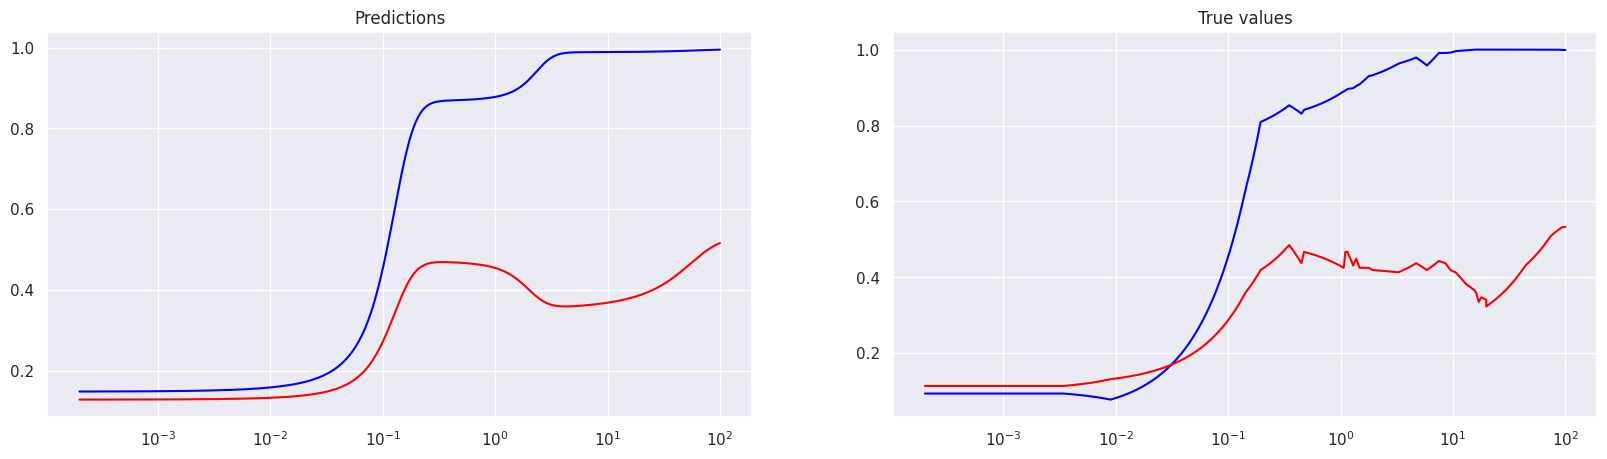

Epoch 276 - loss: 0.0010776733979582787
Epoch 277 - loss: 0.0010731460060924292
Epoch 278 - loss: 0.001059981295838952
Epoch 279 - loss: 0.001055526314303279
Epoch 280 - loss: 0.0010585484560579062
Epoch 281 - loss: 0.0010633998317644
Epoch 282 - loss: 0.0010706689208745956
Epoch 283 - loss: 0.0010631404584273696
Epoch 284 - loss: 0.00105540850199759
Epoch 285 - loss: 0.0010478696785867214
Epoch 286 - loss: 0.0010460529010742903
Epoch 287 - loss: 0.0010486863320693374
Epoch 288 - loss: 0.0010517614427953959
Epoch 289 - loss: 0.0010549545986577868
Epoch 290 - loss: 0.001049185637384653
Epoch 291 - loss: 0.001044146716594696
Epoch 292 - loss: 0.0010384710039943457
Epoch 293 - loss: 0.0010358304716646671
Epoch 294 - loss: 0.0010355727281421423
Epoch 295 - loss: 0.0010361387394368649
Epoch 296 - loss: 0.0010375113924965262
Epoch 297 - loss: 0.001036639790982008
Epoch 298 - loss: 0.001035694731399417
Epoch 299 - loss: 0.0010325259063392878
Epoch 300 - loss: 0.001030209008604288


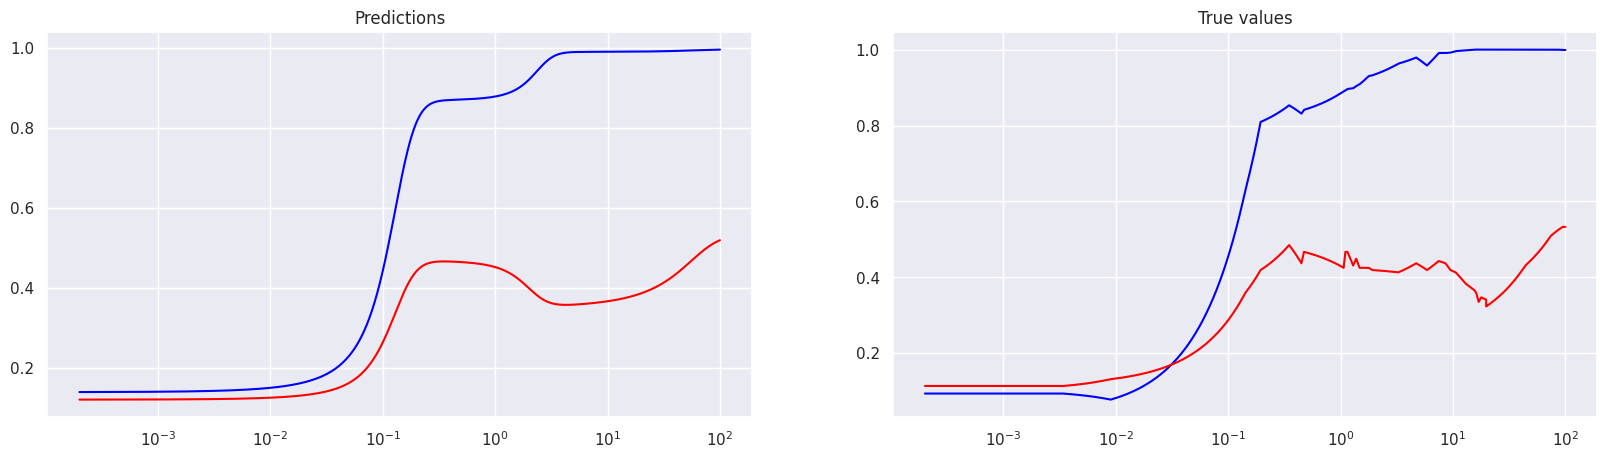

Epoch 301 - loss: 0.001027022604830563
Epoch 302 - loss: 0.0010246816091239452
Epoch 303 - loss: 0.0010228639002889395
Epoch 304 - loss: 0.0010213392088189721
Epoch 305 - loss: 0.0010203272104263306
Epoch 306 - loss: 0.001019615912809968
Epoch 307 - loss: 0.0010189920431002975
Epoch 308 - loss: 0.0010184124112129211
Epoch 309 - loss: 0.0010183145059272647
Epoch 310 - loss: 0.0010176878422498703
Epoch 311 - loss: 0.0010180254466831684
Epoch 312 - loss: 0.001017359783872962
Epoch 313 - loss: 0.0010184948332607746
Epoch 314 - loss: 0.0010178080992773175
Epoch 315 - loss: 0.0010202641133219004
Epoch 316 - loss: 0.0010184462880715728
Epoch 317 - loss: 0.0010203446727246046
Epoch 318 - loss: 0.0010158898076042533
Epoch 319 - loss: 0.0010149438166990876
Epoch 320 - loss: 0.0010094516910612583
Epoch 321 - loss: 0.0010061062639579177
Epoch 322 - loss: 0.0010017722379416227
Epoch 323 - loss: 0.000998853356577456
Epoch 324 - loss: 0.0009971195831894875
Epoch 325 - loss: 0.0009964632336050272


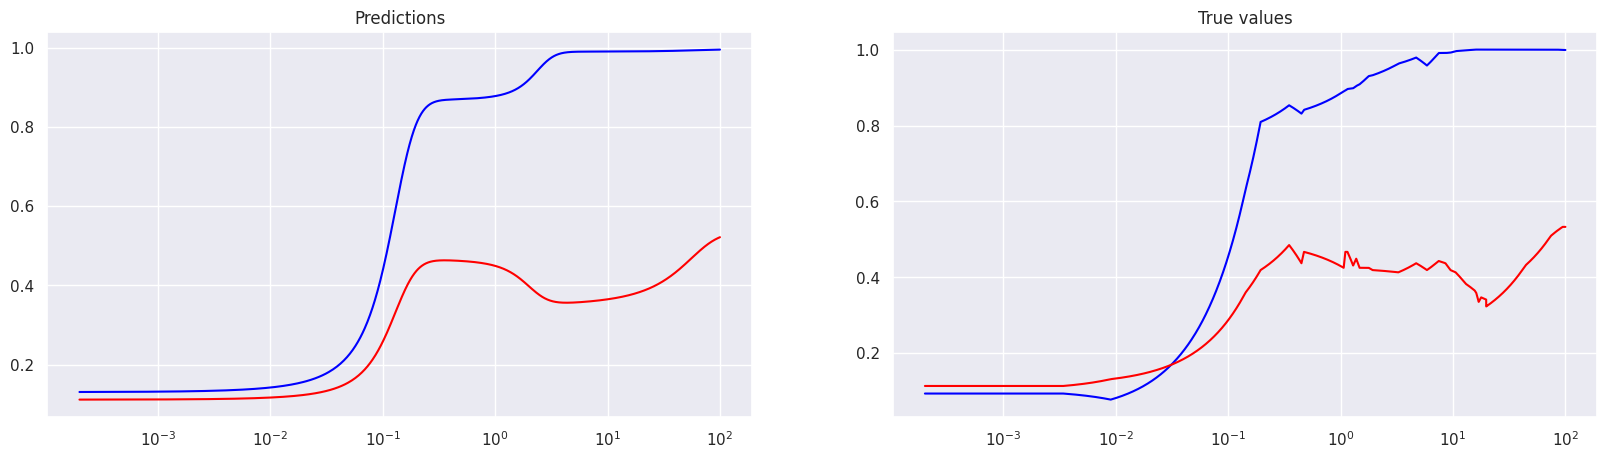

Epoch 326 - loss: 0.0009965085191652179
Epoch 327 - loss: 0.0009964860510081053
Epoch 328 - loss: 0.0009967252844944596
Epoch 329 - loss: 0.0009956094436347485
Epoch 330 - loss: 0.0009950771927833557
Epoch 331 - loss: 0.000993274268694222
Epoch 332 - loss: 0.0009923932375386357
Epoch 333 - loss: 0.0009905874030664563
Epoch 334 - loss: 0.0009896716801449656
Epoch 335 - loss: 0.0009880540892481804
Epoch 336 - loss: 0.0009874011157080531
Epoch 337 - loss: 0.000986220664344728
Epoch 338 - loss: 0.0009862631559371948
Epoch 339 - loss: 0.0009855456883087754
Epoch 340 - loss: 0.000986701576039195
Epoch 341 - loss: 0.0009862668812274933
Epoch 342 - loss: 0.00098918448202312
Epoch 343 - loss: 0.0009884368628263474
Epoch 344 - loss: 0.0009929552907124162
Epoch 345 - loss: 0.000989403109997511
Epoch 346 - loss: 0.0009914810070767999
Epoch 347 - loss: 0.0009839542908594012
Epoch 348 - loss: 0.0009804111905395985
Epoch 349 - loss: 0.0009737578802742064
Epoch 350 - loss: 0.0009696791530586779


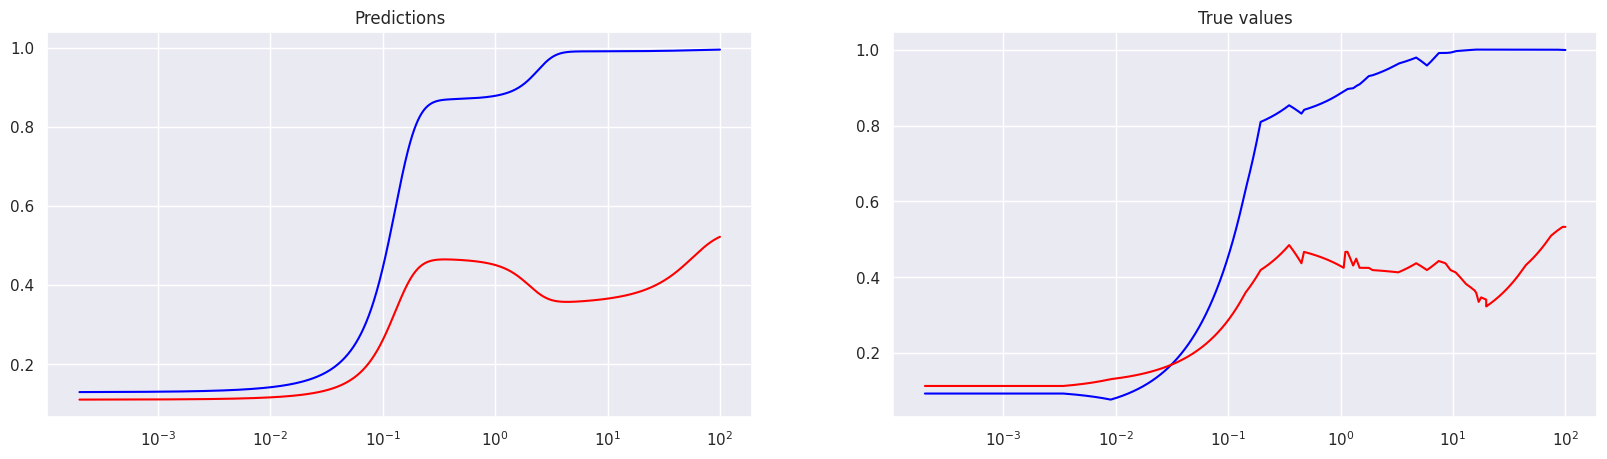

Epoch 351 - loss: 0.0009673952008597553
Epoch 352 - loss: 0.000967017316725105
Epoch 353 - loss: 0.0009678796632215381
Epoch 354 - loss: 0.0009684128453955054
Epoch 355 - loss: 0.0009692747262306511
Epoch 356 - loss: 0.0009677125490270555
Epoch 357 - loss: 0.0009668811690062284
Epoch 358 - loss: 0.0009642526274546981
Epoch 359 - loss: 0.0009625726379454136
Epoch 360 - loss: 0.0009603506186977029
Epoch 361 - loss: 0.0009587940294295549
Epoch 362 - loss: 0.0009572093840688467
Epoch 363 - loss: 0.0009559912141412497
Epoch 364 - loss: 0.0009548201342113316
Epoch 365 - loss: 0.0009538952726870775
Epoch 366 - loss: 0.0009530436946079135
Epoch 367 - loss: 0.0009525848436169326
Epoch 368 - loss: 0.0009523587068542838
Epoch 369 - loss: 0.0009534049313515425
Epoch 370 - loss: 0.0009550687973387539
Epoch 371 - loss: 0.0009618584299460053
Epoch 372 - loss: 0.0009677226189523935
Epoch 373 - loss: 0.0009922032477334142
Epoch 374 - loss: 0.0009897546842694283
Epoch 375 - loss: 0.00101762218400836


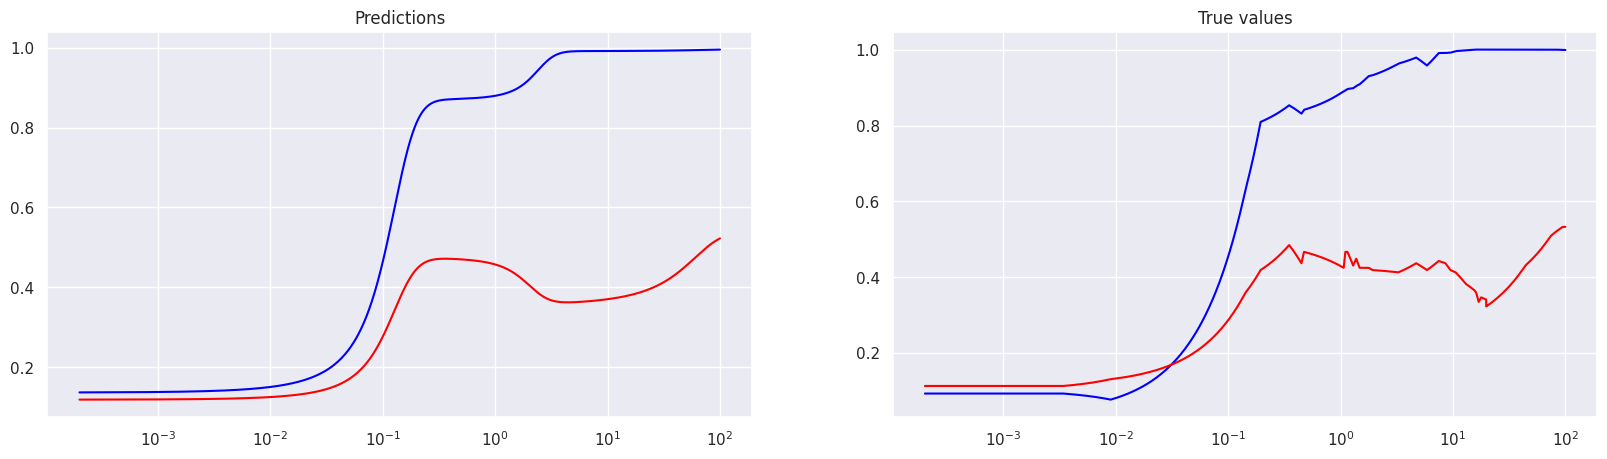

Epoch 376 - loss: 0.0009726076386868954
Epoch 377 - loss: 0.0009502285975031555
Epoch 378 - loss: 0.0009419152047485113
Epoch 379 - loss: 0.0009522975306026638
Epoch 380 - loss: 0.0009692299645394087
Epoch 381 - loss: 0.0009542513289488852
Epoch 382 - loss: 0.0009404104785062373
Epoch 383 - loss: 0.0009414320811629295
Epoch 384 - loss: 0.00095028814394027
Epoch 385 - loss: 0.0009542383486405015
Epoch 386 - loss: 0.0009398958645761013
Epoch 387 - loss: 0.0009349846513941884
Epoch 388 - loss: 0.0009422068251296878
Epoch 389 - loss: 0.0009434029343537986
Epoch 390 - loss: 0.0009397056419402361
Epoch 391 - loss: 0.000931820017285645
Epoch 392 - loss: 0.0009301571408286691
Epoch 393 - loss: 0.0009348576422780752
Epoch 394 - loss: 0.0009361818665638566
Epoch 395 - loss: 0.0009352887282148004
Epoch 396 - loss: 0.0009291576570831239
Epoch 397 - loss: 0.0009245838737115264
Epoch 398 - loss: 0.0009242697851732373
Epoch 399 - loss: 0.0009265323169529438
Epoch 400 - loss: 0.0009297131327912211


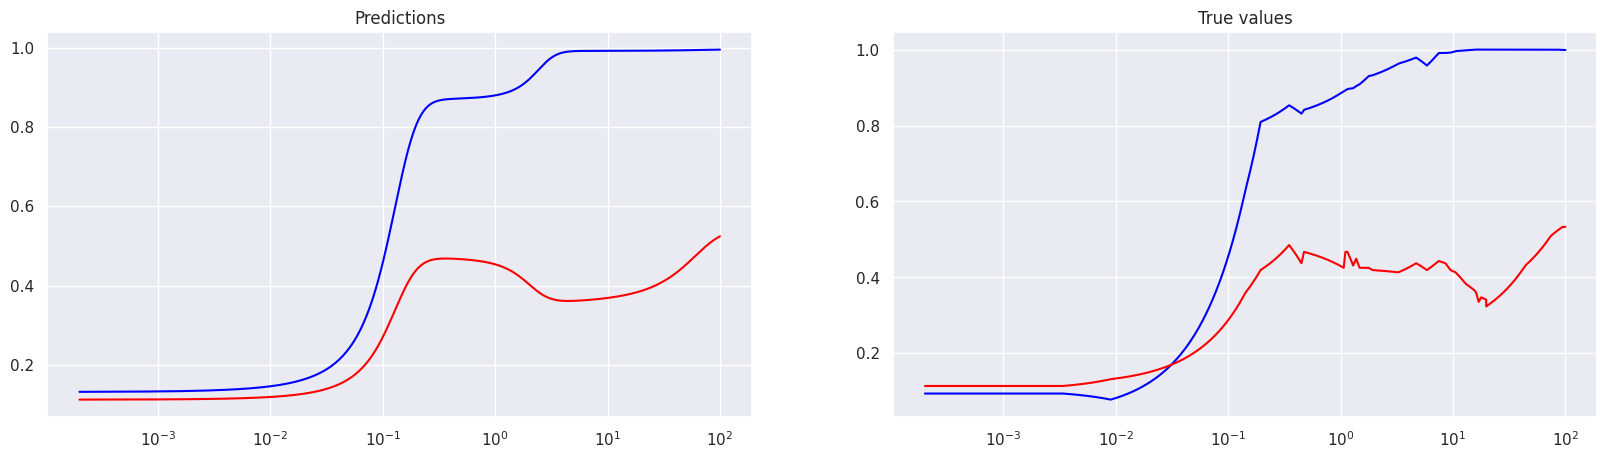

Epoch 401 - loss: 0.000929232279304415
Epoch 402 - loss: 0.0009278831421397626
Epoch 403 - loss: 0.000923119718208909
Epoch 404 - loss: 0.0009201999637298286
Epoch 405 - loss: 0.0009176564053632319
Epoch 406 - loss: 0.0009166230447590351
Epoch 407 - loss: 0.000916139455512166
Epoch 408 - loss: 0.0009162731003016233
Epoch 409 - loss: 0.0009172005811706185
Epoch 410 - loss: 0.0009179636253975332
Epoch 411 - loss: 0.0009209657437168062
Epoch 412 - loss: 0.0009219672065228224
Epoch 413 - loss: 0.0009281251695938408
Epoch 414 - loss: 0.0009291725000366569
Epoch 415 - loss: 0.0009425456519238651
Epoch 416 - loss: 0.0009363482240587473
Epoch 417 - loss: 0.0009422486764378846
Epoch 418 - loss: 0.0009228454437106848
Epoch 419 - loss: 0.0009128516539931297
Epoch 420 - loss: 0.0009061851305887103
Epoch 421 - loss: 0.0009071176173165441
Epoch 422 - loss: 0.0009123045019805431
Epoch 423 - loss: 0.0009120047325268388
Epoch 424 - loss: 0.0009090612293221056
Epoch 425 - loss: 0.0009033678798004985


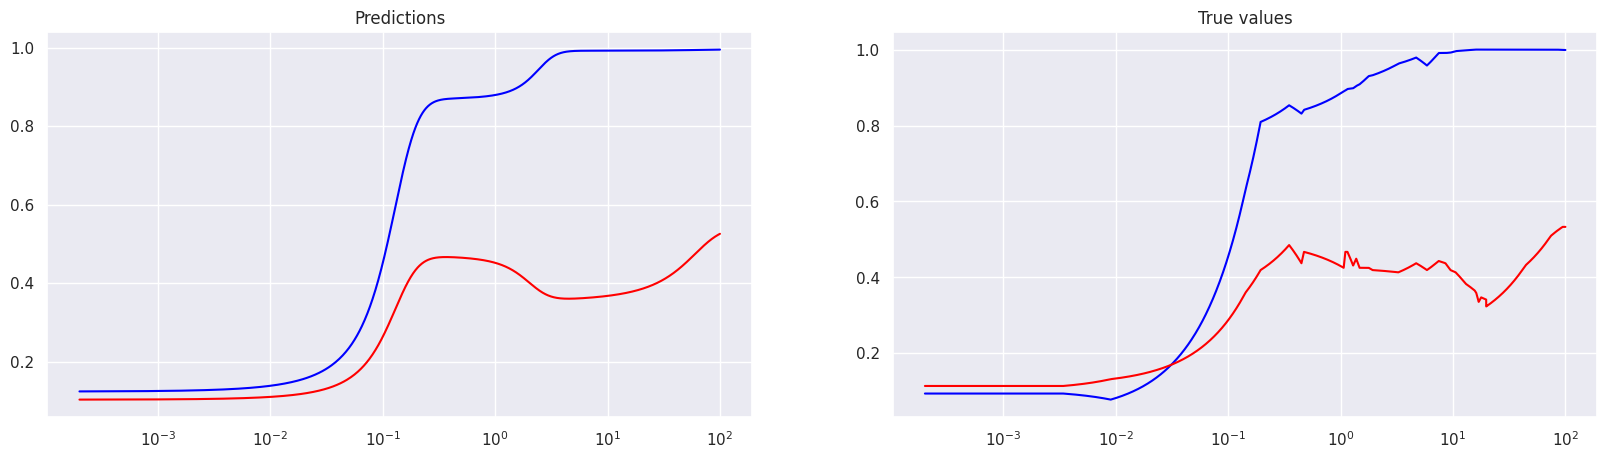

Epoch 426 - loss: 0.0009022158337756991
Epoch 427 - loss: 0.000904723652638495
Epoch 428 - loss: 0.0009053043322637677
Epoch 429 - loss: 0.0009038956486620009
Epoch 430 - loss: 0.0008999411948025227
Epoch 431 - loss: 0.000898052821867168
Epoch 432 - loss: 0.0008987090550363064
Epoch 433 - loss: 0.0008997383993119001
Epoch 434 - loss: 0.0009002368897199631
Epoch 435 - loss: 0.0008980923448689282
Epoch 436 - loss: 0.0008958278922364116
Epoch 437 - loss: 0.0008938251994550228
Epoch 438 - loss: 0.0008929315954446793
Epoch 439 - loss: 0.0008928651222959161
Epoch 440 - loss: 0.0008931563352234662
Epoch 441 - loss: 0.0008938352111726999
Epoch 442 - loss: 0.0008937671664170921
Epoch 443 - loss: 0.0008945006411522627
Epoch 444 - loss: 0.0008941051783040166
Epoch 445 - loss: 0.0008954961085692048
Epoch 446 - loss: 0.0008951795753091574
Epoch 447 - loss: 0.0008981111459434032
Epoch 448 - loss: 0.0008976158569566905
Epoch 449 - loss: 0.000902548257727176
Epoch 450 - loss: 0.0009002983570098877


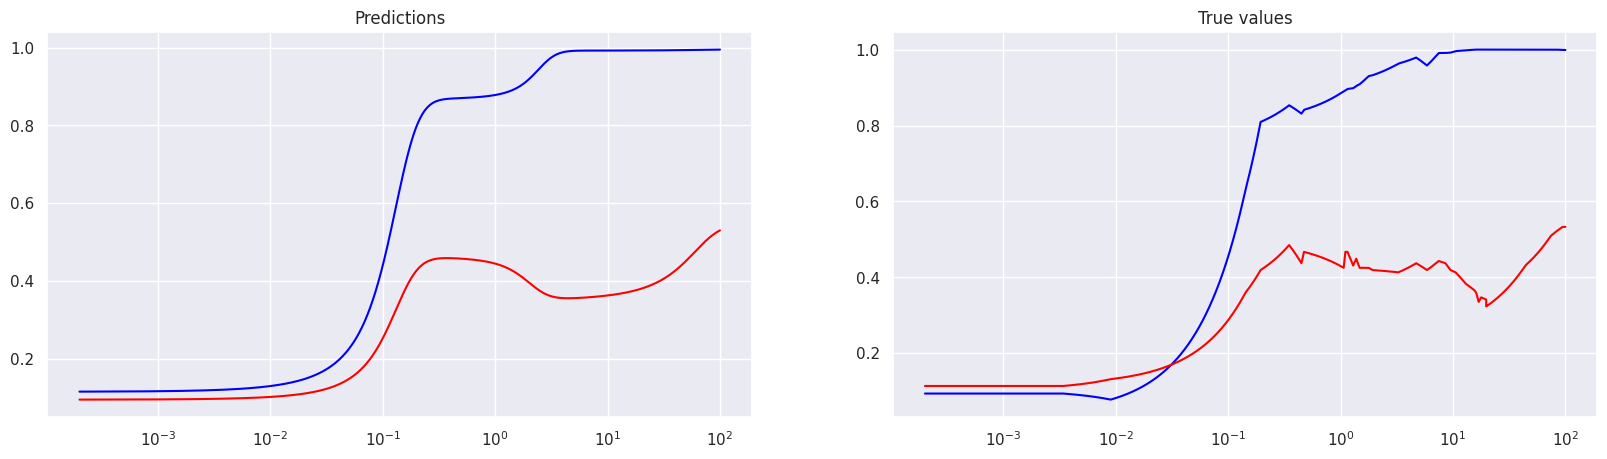

Epoch 451 - loss: 0.0009049546206369996
Epoch 452 - loss: 0.0008981434511952102
Epoch 453 - loss: 0.0008961872081272304
Epoch 454 - loss: 0.0008881317335180938
Epoch 455 - loss: 0.0008834756445139647
Epoch 456 - loss: 0.0008813482709228992
Epoch 457 - loss: 0.0008820542134344578
Epoch 458 - loss: 0.0008842007373459637
Epoch 459 - loss: 0.0008842615643516183
Epoch 460 - loss: 0.0008833848987706006
Epoch 461 - loss: 0.0008802384836599231
Epoch 462 - loss: 0.0008780272910371423
Epoch 463 - loss: 0.0008772040600888431
Epoch 464 - loss: 0.0008775644819252193
Epoch 465 - loss: 0.0008783389930613339
Epoch 466 - loss: 0.0008780851494520903
Epoch 467 - loss: 0.0008775406749919057
Epoch 468 - loss: 0.0008758977637626231
Epoch 469 - loss: 0.000874470395501703
Epoch 470 - loss: 0.0008731883717700839
Epoch 471 - loss: 0.0008723371429368854
Epoch 472 - loss: 0.0008718509925529361
Epoch 473 - loss: 0.0008716172305867076
Epoch 474 - loss: 0.0008715958683751523
Epoch 475 - loss: 0.0008715951116755605


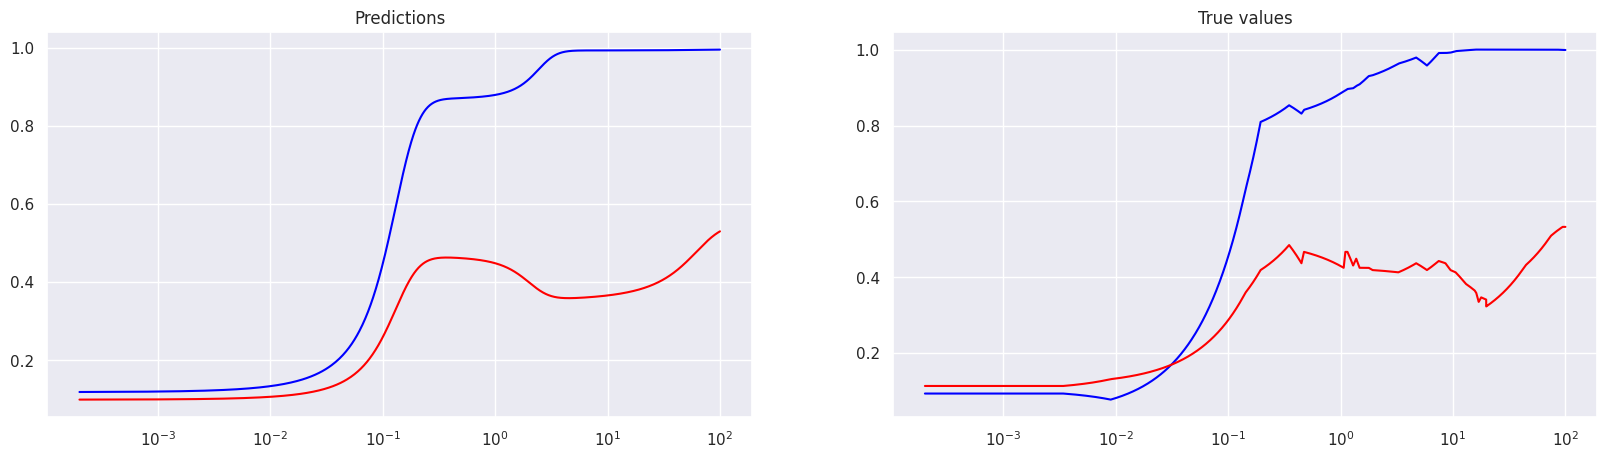

Epoch 476 - loss: 0.0008720284095034003
Epoch 477 - loss: 0.0008723093196749687
Epoch 478 - loss: 0.0008739415789023042
Epoch 479 - loss: 0.0008750366978347301
Epoch 480 - loss: 0.0008801309741102159
Epoch 481 - loss: 0.0008822292438708246
Epoch 482 - loss: 0.0008944090222939849
Epoch 483 - loss: 0.0008913641213439405
Epoch 484 - loss: 0.0009022029698826373
Epoch 485 - loss: 0.0008839762303978205
Epoch 486 - loss: 0.0008745924569666386
Epoch 487 - loss: 0.0008650340605527163
Epoch 488 - loss: 0.0008650177624076605
Epoch 489 - loss: 0.0008710261899977922
Epoch 490 - loss: 0.0008711054106242955
Epoch 491 - loss: 0.0008673280826769769
Epoch 492 - loss: 0.0008619669824838638
Epoch 493 - loss: 0.0008631508680991828
Epoch 494 - loss: 0.0008670114912092686
Epoch 495 - loss: 0.000864543835632503
Epoch 496 - loss: 0.0008606134215369821
Epoch 497 - loss: 0.0008596329716965556
Epoch 498 - loss: 0.000861567270476371
Epoch 499 - loss: 0.0008625489426776767


PatternLearningModel({'pattern_0/strength': tensor(0.8598), 'pattern_0/speed': tensor(24.1215), 'pattern_0/onset': tensor(0.1012), 'pattern_0/generalization': tensor(0.5017), 'pattern_1/strength': tensor(0.9493), 'pattern_1/speed': tensor(1.7670), 'pattern_1/onset': tensor(2.1642), 'pattern_1/generalization': tensor(0.1769), 'pattern_2/strength': tensor(0.3363), 'pattern_2/speed': tensor(0.0432), 'pattern_2/onset': tensor(48.4098), 'pattern_2/generalization': tensor(1.7254)})

In [51]:
model = PatternLearningModel(max_time=100.)

for i, pattern in enumerate(model.patterns):
    pattern.onset.data = torch.tensor(0.1 * 10 ** (i * 1.25))
    pattern.speed.data = torch.tensor(50. * 10 ** (-i))
    # pattern._strength.data = pattern._inv_sigmoid(torch.tensor([.8, 1.0, 1.0][i]))
    # pattern._generalization.data = torch.log(torch.tensor([.3, 0.01, .69][i]))

print(model.patterns)

def callback(x): 
    plot_patterns(x, rescaled_run, log=True)
    plt.show()

callback(model)

model.fit(rescaled_run, lr=0.1, num_epochs=500, callback=callback, callback_ivl=25)

In [79]:
model.rescale(100) 
model.patterns

ModuleList(
  (0): Pattern(strength=0.8598001003265381, speed=24.121509552001953, onset=0.10115106403827667, generalization=0.5016812682151794)
  (1): Pattern(strength=0.9492841958999634, speed=1.7669602632522583, onset=2.1641852855682373, generalization=0.1769353449344635)
  (2): Pattern(strength=0.33629870414733887, speed=0.04316259175539017, onset=48.40985107421875, generalization=1.7254242897033691)
)

In [177]:
model.patterns[1].speed.data /= 4.

[2.00000e-04 4.00000e-04 6.00000e-04 ... 9.99992e+01 9.99994e+01
 9.99996e+01]


/tmp/ipykernel_409543/2695227391.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])


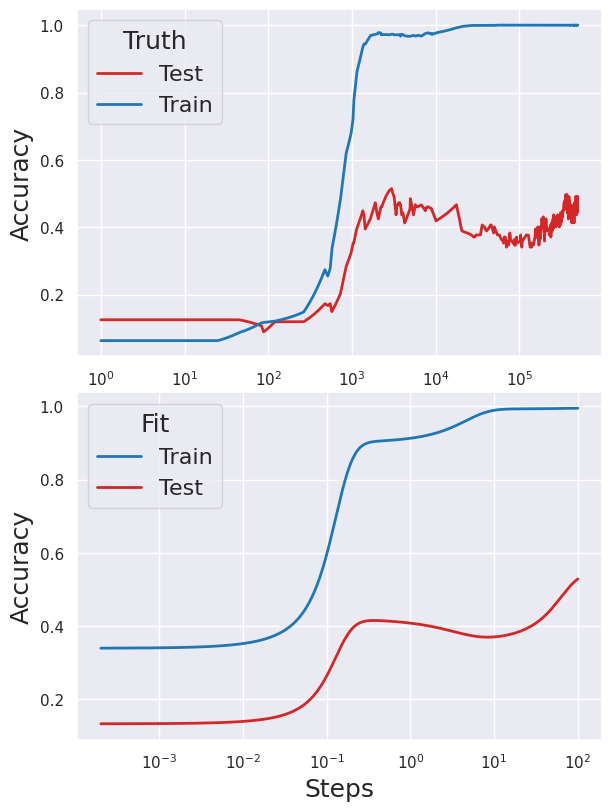

In [178]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
# ax1.set_xlabel("Steps", fontsize=18)
# ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
ax1.set_xscale("log")
ax1.legend(title="Truth", fontsize=16, title_fontsize=18)

min_step, max_step = 0, 100 # run["_step"].max()

ts = run["_step"].values * 100 / 500_000
print(ts)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Steps", fontsize=18)
# ax2.set_title("Fit", )
ax2.legend(title="Fit", fontsize=16, title_fontsize=18)

ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax2.set_xlim(10, 100)
ax2.set_xscale("log")
# ax2.set_xticks([0.01, 0.1, 1, 10, 100])

fig.tight_layout(pad=0.25)

# Already in log scale
# train_ys, test_ys

# Fit the sweeps

In [12]:
api = wandb.Api()
runs = api.runs(f"jqhoogland/fit-toy-model")
[run for run in runs]

[<Run jqhoogland/fit-toy-model/adwkvhjw (running)>,
 <Run jqhoogland/fit-toy-model/n35nig8t (running)>,
 <Run jqhoogland/fit-toy-model/qc4itmz1 (running)>,
 <Run jqhoogland/fit-toy-model/0v1thdzj (finished)>,
 <Run jqhoogland/fit-toy-model/1gthqqg5 (finished)>,
 <Run jqhoogland/fit-toy-model/5s56iliv (crashed)>]

In [28]:
mw_fit_run_id = "1gthqq5"
run = runs[2]
df = run.history()

col = "d_model"
unique_vals = df.loc[:, col].unique()
print(unique_vals)
df

[  1   2   3   4   5   6   8   9  11  14  17  20  25  30  37  44  54  65
  79  95 115 140 169 205 248 300]


,pattern_0/onset,_step,modulus,log,pattern_1/speed,d_vocab,num_training_steps,weight_decay,_runtime,sweep,...,frac_train,pattern_0/generalization,test_acc_criterion,embed_dim,num_ctx,batch_size,_timestamp,frac_label_noise,pattern_2/onset,d_head
0,1586.732178,0,113,True,-0.006830,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.213087,1,300,3,3830,1.683837e+09,0,7410.460938,32
1,1062.660767,1,113,True,-0.006865,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.264094,1,300,3,3830,1.683837e+09,0,7424.370117,32
2,1223.991821,2,113,True,-0.006661,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.299968,1,300,3,3830,1.683837e+09,0,7338.598145,32
3,1343.376587,3,113,True,-0.007134,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.199818,1,300,3,3830,1.683837e+09,0,8287.747070,32
4,1485.789429,4,113,True,-0.006551,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.373736,1,300,3,3830,1.683837e+09,0,7520.019531,32
5,1435.536377,5,113,True,-0.004474,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.188602,1,300,3,3830,1.683837e+09,0,7554.412109,32
6,1208.405396,6,113,True,-0.006050,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.638340,1,300,3,3830,1.683837e+09,0,6846.722656,32
7,1379.252686,7,113,True,-0.006602,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.036816,1,300,3,3830,1.683837e+09,0,9516.064453,32
8,2736.685059,8,113,True,0.005848,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.019606,1,300,3,3830,1.683837e+09,0,7656.134766,32
9,2740.774902,9,113,True,0.007786,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.024199,1,300,3,3830,1.683837e+09,0,7695.309570,32


In [35]:
def df_row_to_toy_model(row):
    model = PatternLearningModel(max_time=1.)

    for i, pattern in enumerate(model.patterns):
        pattern.onset.data = torch.tensor(row[f"pattern_{i}/onset"])
        pattern.speed.data = torch.tensor(row[f"pattern_{i}/speed"])
        pattern._strength.data = pattern._inv_sigmoid(torch.tensor(row[f"pattern_{i}/strength"]))  # type: ignore
        pattern._generalization.data = torch.log(torch.tensor(row[f"pattern_{i}/generalization"]))

    return model

D_MODEL = 115
co9l = "d_model"
model_entry = df.loc[df[col] == D_MODEL, :].iloc[0, :]
print(model_entry)
model = df_row_to_toy_model(model_entry)
model.rescale(100)
model.patterns

pattern_0/onset                   3307.669922
_step                                      20
modulus                                   113
log                                      True
pattern_1/speed                       0.00761
d_vocab                                   114
num_training_steps                     100000
weight_decay                              0.3
_runtime                             2.410218
sweep                                l1b2mmci
pattern_1/onset                   4938.347168
lr                                      0.001
seed                                        0
pattern_1/generalization             0.701577
pattern_2/generalization             6.939834
num_layers                                  1
log_interval                               10
pattern_1/strength                     0.9862
pattern_0/strength                   0.077263
pattern_0/speed                      0.004219
d_model                                   115
pattern_2/strength                

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ModuleList(
  (0): Pattern(strength=0.0772629827260971, speed=0.4218541085720062, onset=33.076698303222656, generalization=0.014402443543076515)
  (1): Pattern(strength=0.9861999750137329, speed=0.760972797870636, onset=49.38347244262695, generalization=0.7015765905380249)
  (2): Pattern(strength=0.9925130605697632, speed=0.5755707621574402, onset=75.50422668457031, generalization=6.939833641052246)
)

In [37]:
# Get corresponding original run
og_df = get_history(DM_SWEEP_ID, unique_cols="d_model")
run = og_df.loc[og_df.d_model==D_MODEL,:] #.plot(x="_step", y="test/acc")

/tmp/ipykernel_39642/2223921967.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_39642/2223921967.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])


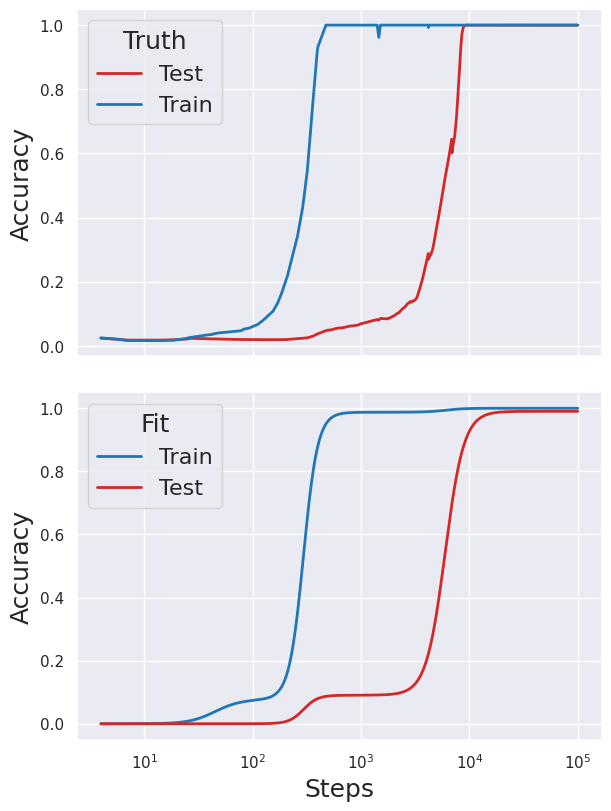

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
# ax1.set_xlabel("Steps", fontsize=18)
ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
ax1.set_xscale("log")
ax1.legend(title="Truth", fontsize=16, title_fontsize=18)

min_step, max_step = og_df["_step"].min(), 100 # run["_step"].max()

ts = np.linspace(12, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Steps", fontsize=18)
# ax2.set_title("Fit", )
ax2.legend(title="Fit", fontsize=16, title_fontsize=18)

ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax2.set_xlim(10, 100)

fig.tight_layout(pad=0.25)

# Already in log scale
# train_ys, test_ys

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
# ax1.set_xlabel("Steps", fontsize=18)
ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
ax1.set_xscale("log")
ax1.legend(title="Truth", fontsize=16, title_fontsize=18)

min_step, max_step = og_df["_step"].min(), 100 # run["_step"].max()

ts = np.linspace(12, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Steps", fontsize=18)
# ax2.set_title("Fit", )
ax2.legend(title="Fit", fontsize=16, title_fontsize=18)
ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax2.set_xlim(10, 100)

fig.tight_layout(pad=0.25)

# Already in log scale
# train_ys, test_ys

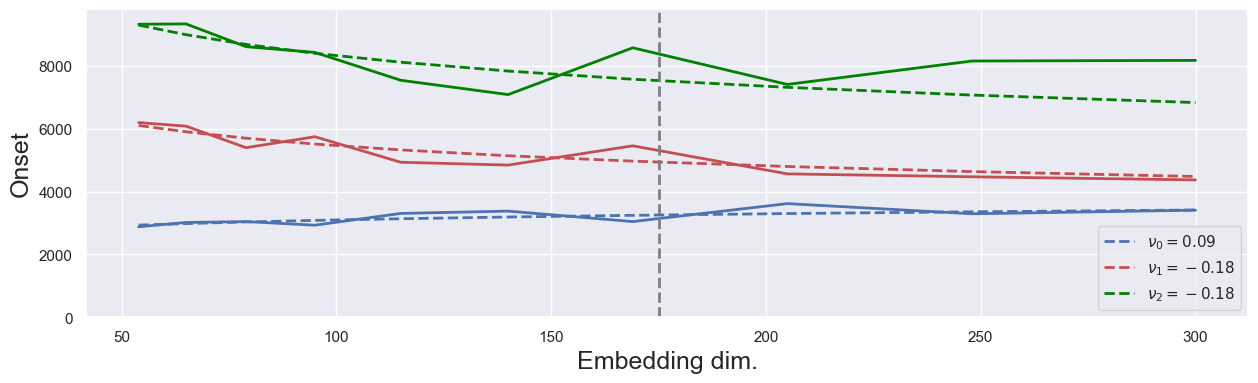

In [70]:
# Ignore any d_model < 50
df_cleaned = df.loc[df["d_model"] >= 50, :]
d_models = df_cleaned.loc[:, "d_model"].unique()

# Scaling analysis
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

colors = [BLUE, RED, "green"]
y_max = 0

for i in range(3):
    slice = df_cleaned.loc[:, f"pattern_{i}/onset"]
    y_max = max(y_max, slice.max())
    ax.plot(d_models, slice, label=f"", color=colors[i], linewidth=2)

ax.set_xlabel("d_model", fontsize=18)
ax.set_ylabel("Onset", fontsize=18)


# Fit a power-law to the onsets 
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

def fit_power_law(x, y):
    popt, pcov = curve_fit(power_law, x, y)
    return popt


CUTOFF = 175

# Fit power law to onset
for i in range(3):
    # Train up to a specific point
    df_to_fit = df_cleaned.loc[df_cleaned["d_model"] <= CUTOFF, :]
    d_models_to_fit = df_to_fit.loc[:, "d_model"].unique()

    onset_popt = fit_power_law(d_models_to_fit, df_to_fit.loc[:, f"pattern_{i}/onset"])
    exponent = round(onset_popt[1], 2)
    ax.plot(d_models, power_law(d_models, *onset_popt), label=f"$\\nu_{i} = {exponent}$", color=colors[i], linestyle="--", linewidth=2)

ax.vlines(CUTOFF, 0, y_max * 1.05, color="grey", linestyle="--", linewidth=2)
ax.set_xlabel("Embedding dim.", fontsize=18)
ax.set_ylim(0, y_max * 1.05)

ax.legend()

/tmp/ipykernel_409543/540945436.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_to_decompose.sort_values(by="_step", inplace=True)
/tmp/ipykernel_409543/540945436.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_to_decompose["test/acc"] = gaussian_filter1d(run_to_decompose["test/acc"], sigma=15)
/tmp/ipykernel_409543/540945436.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

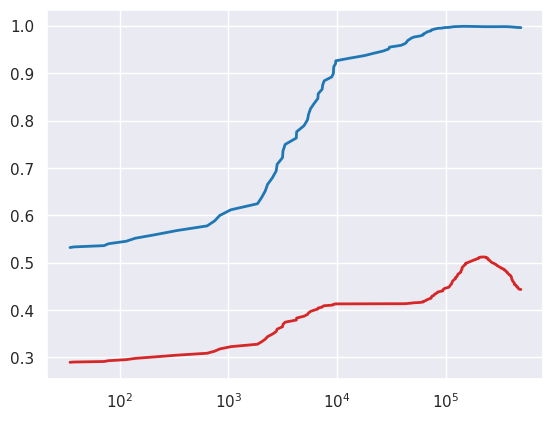

In [95]:
# Fit the model & show the pattern. 

run_to_decompose = interp_sweep.loc[interp_sweep.lr_factor == 6, :]
# Sort
run_to_decompose.sort_values(by="_step", inplace=True)
steps = run_to_decompose._step

# Apply a gaussian filter with sigma=2
from scipy.ndimage import gaussian_filter1d

run_to_decompose["test/acc"] = gaussian_filter1d(run_to_decompose["test/acc"], sigma=15)
run_to_decompose["train/acc"] = gaussian_filter1d(run_to_decompose["train/acc"], sigma=15)

plt.plot(steps, run_to_decompose["test/acc"], label="Test", color=RED, linewidth=2)
plt.plot(steps, run_to_decompose["train/acc"], label="Train", color=BLUE, linewidth=2)

plt.xscale("log")

run_to_decompose_rescaled = rescale_run(run_to_decompose, new_max=100)


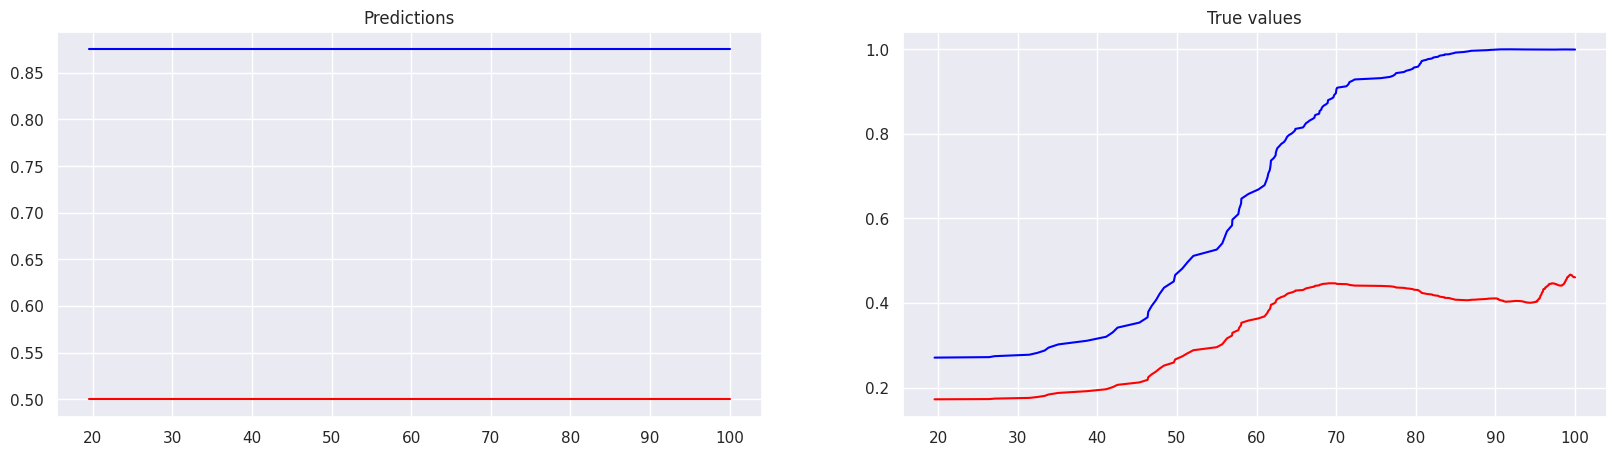

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - loss: 0.039858635514974594


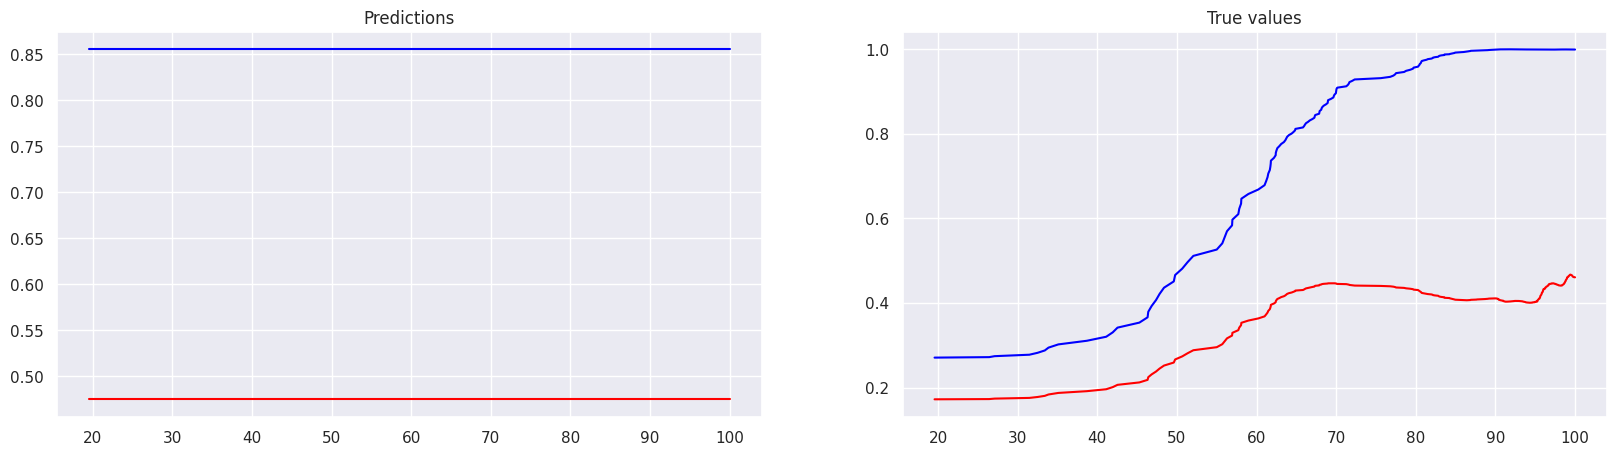

Epoch 1 - loss: 0.03857443481683731
Epoch 2 - loss: 0.03909042477607727
Epoch 3 - loss: 0.039265766739845276
Epoch 4 - loss: 0.03888075053691864
Epoch 5 - loss: 0.03856044262647629
Epoch 6 - loss: 0.038498394191265106
Epoch 7 - loss: 0.03841610625386238
Epoch 8 - loss: 0.03802547603845596
Epoch 9 - loss: 0.037287112325429916
Epoch 10 - loss: 0.03629075735807419
Epoch 11 - loss: 0.035145748406648636
Epoch 12 - loss: 0.033965788781642914
Epoch 13 - loss: 0.03289315104484558
Epoch 14 - loss: 0.032070208340883255
Epoch 15 - loss: 0.03153051808476448
Epoch 16 - loss: 0.03114066831767559
Epoch 17 - loss: 0.030748026445508003
Epoch 18 - loss: 0.030343100428581238
Epoch 19 - loss: 0.030026793479919434
Epoch 20 - loss: 0.02990177646279335
Epoch 21 - loss: 0.02999171055853367
Epoch 22 - loss: 0.03021114133298397
Epoch 23 - loss: 0.030416550114750862
Epoch 24 - loss: 0.03051588498055935
Epoch 25 - loss: 0.03052421286702156


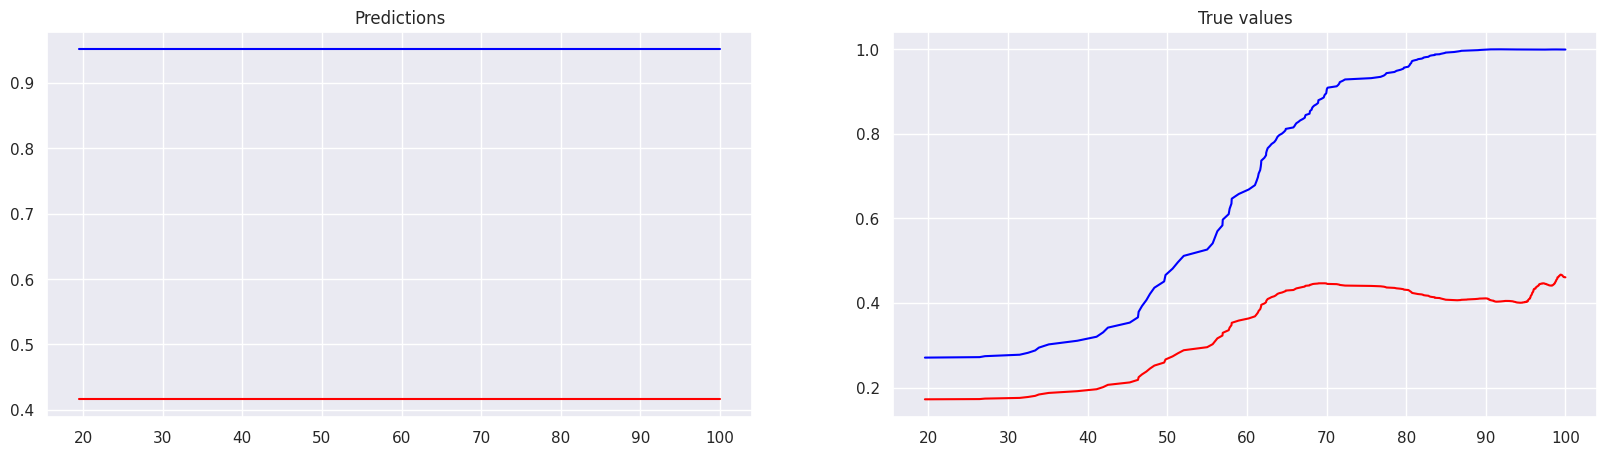

Epoch 26 - loss: 0.03051900491118431
Epoch 27 - loss: 0.030559193342924118
Epoch 28 - loss: 0.030638298019766808
Epoch 29 - loss: 0.030701184645295143
Epoch 30 - loss: 0.03070010244846344
Epoch 31 - loss: 0.03063318505883217
Epoch 32 - loss: 0.030537845566868782
Epoch 33 - loss: 0.030456120148301125
Epoch 34 - loss: 0.030402377247810364
Epoch 35 - loss: 0.030356958508491516
Epoch 36 - loss: 0.030290547758340836
Epoch 37 - loss: 0.030195388942956924
Epoch 38 - loss: 0.030092263594269753
Epoch 39 - loss: 0.03001013584434986
Epoch 40 - loss: 0.029961928725242615
Epoch 41 - loss: 0.0299382321536541
Epoch 42 - loss: 0.029920758679509163
Epoch 43 - loss: 0.029900139197707176
Epoch 44 - loss: 0.029881920665502548
Epoch 45 - loss: 0.02987818792462349
Epoch 46 - loss: 0.029894327744841576
Epoch 47 - loss: 0.029922882094979286
Epoch 48 - loss: 0.029949355870485306
Epoch 49 - loss: 0.029963528737425804
Epoch 50 - loss: 0.029965411871671677


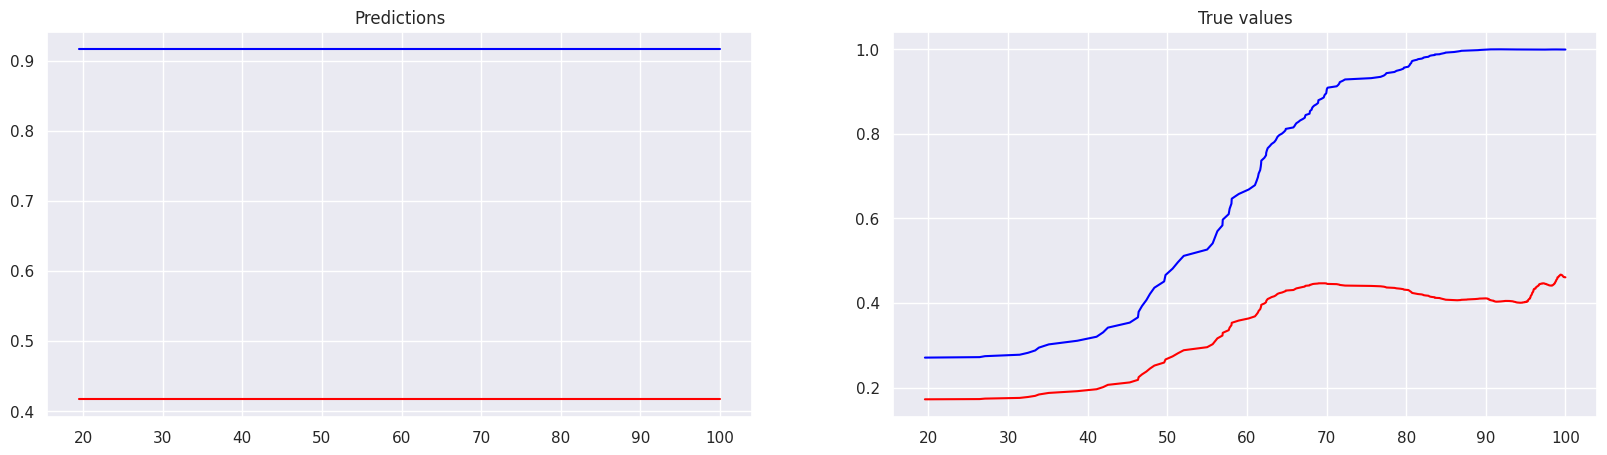

Epoch 51 - loss: 0.029961522668600082
Epoch 52 - loss: 0.029956942424178123
Epoch 53 - loss: 0.02995111234486103
Epoch 54 - loss: 0.029940379783511162
Epoch 55 - loss: 0.029923412948846817
Epoch 56 - loss: 0.029903750866651535
Epoch 57 - loss: 0.029887231066823006
Epoch 58 - loss: 0.029877347871661186
Epoch 59 - loss: 0.029873128980398178
Epoch 60 - loss: 0.02987128123641014
Epoch 61 - loss: 0.02986982837319374
Epoch 62 - loss: 0.029869478195905685
Epoch 63 - loss: 0.029871737584471703
Epoch 64 - loss: 0.029876401647925377
Epoch 65 - loss: 0.02988123893737793
Epoch 66 - loss: 0.029884010553359985
Epoch 67 - loss: 0.029884321615099907
Epoch 68 - loss: 0.02988344617187977
Epoch 69 - loss: 0.029882589355111122
Epoch 70 - loss: 0.02988165244460106
Epoch 71 - loss: 0.029879748821258545
Epoch 72 - loss: 0.02987658977508545
Epoch 73 - loss: 0.02987302839756012
Epoch 74 - loss: 0.029870260506868362
Epoch 75 - loss: 0.02986872009932995


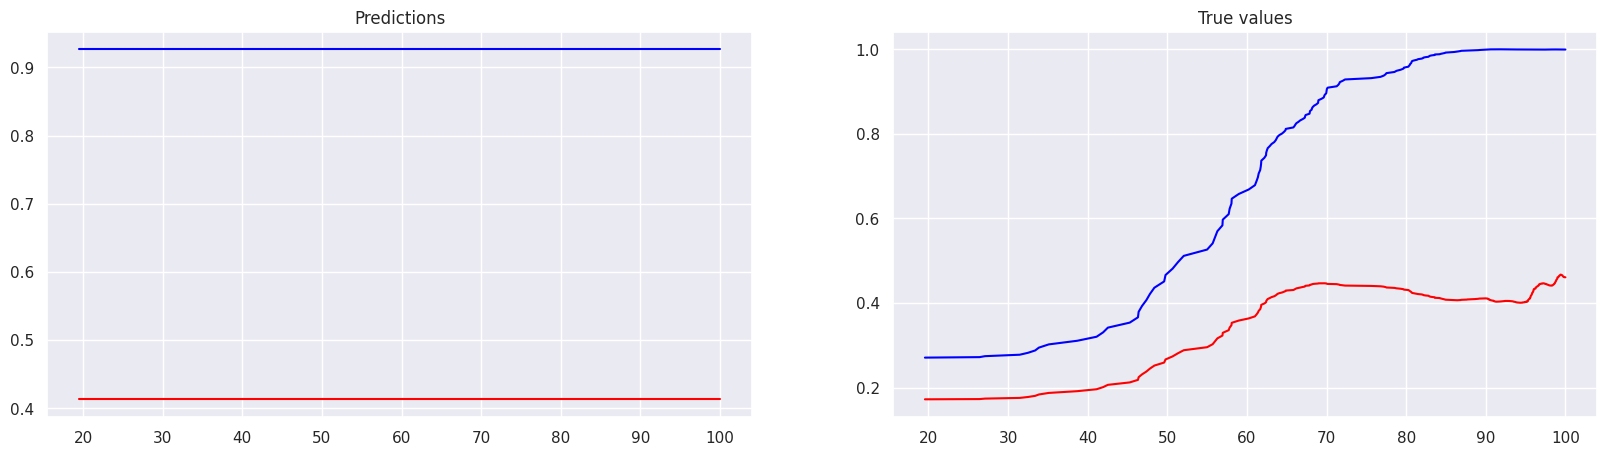

Epoch 76 - loss: 0.029867926612496376
Epoch 77 - loss: 0.02986728399991989
Epoch 78 - loss: 0.029866766184568405
Epoch 79 - loss: 0.029866792261600494
Epoch 80 - loss: 0.029867537319660187
Epoch 81 - loss: 0.0298685971647501
Epoch 82 - loss: 0.02986937388777733
Epoch 83 - loss: 0.02986963465809822
Epoch 84 - loss: 0.029869580641388893
Epoch 85 - loss: 0.029869485646486282
Epoch 86 - loss: 0.02986934222280979
Epoch 87 - loss: 0.02986895479261875
Epoch 88 - loss: 0.029868289828300476
Epoch 89 - loss: 0.029867546632885933
Epoch 90 - loss: 0.029867012053728104
Epoch 91 - loss: 0.029866736382246017
Epoch 92 - loss: 0.029866592958569527
Epoch 93 - loss: 0.029866471886634827
Epoch 94 - loss: 0.02986641228199005
Epoch 95 - loss: 0.029866499826312065
Epoch 96 - loss: 0.02986670844256878
Epoch 97 - loss: 0.029866913333535194
Epoch 98 - loss: 0.029867013916373253
Epoch 99 - loss: 0.029867012053728104


PatternLearningModel({'pattern_0/strength': tensor(0.6620), 'pattern_0/speed': tensor(10.), 'pattern_0/onset': tensor(0.2500), 'pattern_0/generalization': tensor(0.1706), 'pattern_1/strength': tensor(0.6624), 'pattern_1/speed': tensor(10.), 'pattern_1/onset': tensor(0.5000), 'pattern_1/generalization': tensor(0.1702), 'pattern_2/strength': tensor(0.3576), 'pattern_2/speed': tensor(10.), 'pattern_2/onset': tensor(0.7500), 'pattern_2/generalization': tensor(1.5037)})

In [87]:
model = PatternLearningModel()

def callback(x): 
    plot_patterns(x, run_to_decompose_rescaled)
    plt.show()

model.fit(run_to_decompose_rescaled, num_epochs=100, callback=callback, callback_ivl=25)

In [180]:
from scipy.ndimage import gaussian_filter1d

r_uncorrupted = gaussian_filter1d(run["uncorrupted/acc"], 2.)
r_corrupted = gaussian_filter1d(run["corrupted/acc"], 2.)

r_uncorrupted

array([0.11223856, 0.11223856, 0.11223856, ..., 0.99843394, 0.99843394,
       0.99843394])

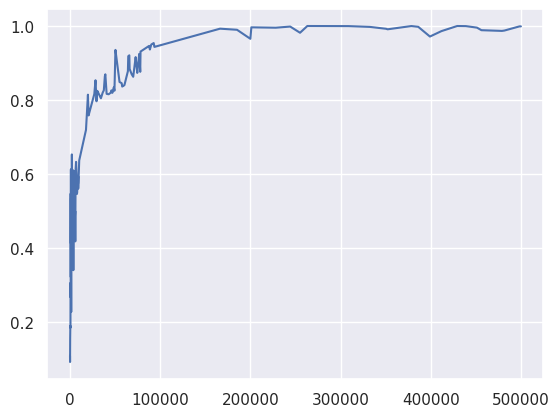

In [167]:
plt.plot(steps, run["corrupted/acc"])

/home/jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_409543/1270688411.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "", "$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$", ])


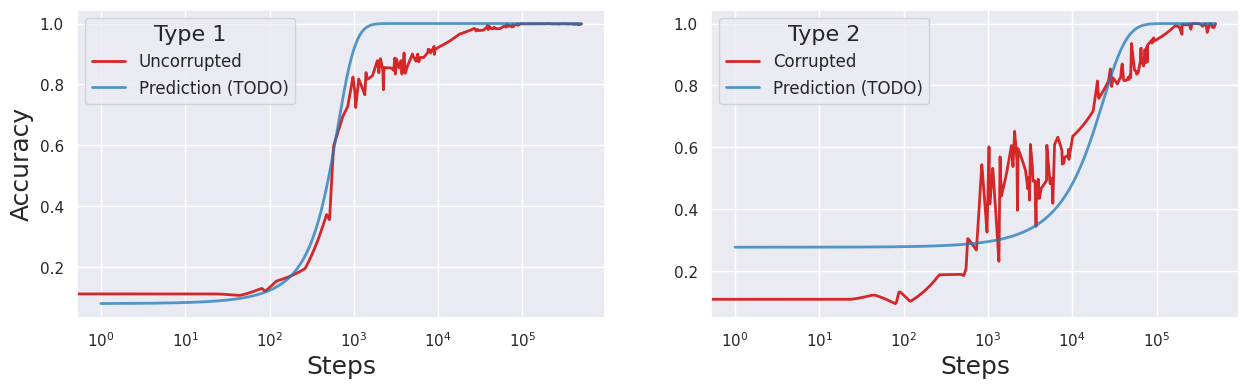

In [183]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

type_1 = [(model.patterns[0](t) / model.patterns[0].strength).detach().float() for t in ts]
type_2 = [(model.patterns[1](t) / model.patterns[1].strength).detach().float() for t in ts]
type_3 = [(model.patterns[2](t) / model.patterns[2].strength).detach().float() for t in ts]

TS = ts * 500_000 / 100

# Plot 1: Uncorrupted data / Type 1 Pattern
ax1.plot(steps, r_uncorrupted, label="Uncorrupted", color=RED, linewidth=2)
ax1.plot(TS, type_1, label="Prediction (TODO)", color=BLUE, linestyle="-", linewidth=2, alpha=0.75)
ax1.legend(title="Type 1", fontsize=12, title_fontsize=16, loc="upper left")

# TODO: Plot pattern 1
# ax1.plot(steps, )

# Plot 2: Corrupted data / Type 2 Pattern
ax2.plot(steps, r_corrupted, label="Corrupted", color=RED, linewidth=2)
ax2.plot(TS, type_2, label="Prediction (TODO)", color=BLUE, linestyle="-", linewidth=2, alpha=0.75)
ax2.legend(title="Type 2", fontsize=12, title_fontsize=16, loc="upper left")


# Plot 3: Type 3 Pattern

# ax3.plot(TS, type_3, label="Prediction (TODO)", color=BLUE, linestyle="--", linewidth=2)
# ax3.legend(title="Type 3", fontsize=12, title_fontsize=16, loc="upper left")

ax1.set_ylabel("Accuracy", fontsize=18)

# for ax in [ax1, ax2, ax3]:
for ax in [ax1, ax2]:
    ax.set_xlabel("Steps", fontsize=18)
    ax.set_xscale("log")
    ax.set_xticklabels(["", "", "$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$", ])

plt.savefig("../figures/pattern-predictions.pdf", bbox_inches="tight")

13          NaN
32          NaN
35          NaN
62     0.120968
71          NaN
         ...   
314         NaN
3           NaN
21          NaN
211         NaN
116         NaN
Name: corrupted/acc, Length: 432, dtype: float64

In [93]:

def get_history(
    *sweep_ids,
    unique_cols: Union[List[str], str] = "weight_decay",
    entity: str = "jqhoogland",
    project: str = "grokking",
    allow_duplicates=False,
    combine_seeds=False,
):
    """
    Gathers all the runs from a series of sweeps and combines them into a single dataframe.

    `unique_col` is used to identify duplicate runs. By default, `"_step"` is added.
    If there are duplicates, the run from the last sweep is kept.
    """
    api = wandb.Api()
    unique_cols = unique_cols if isinstance(unique_cols, list) else [unique_cols]

    def _get_history(sweep_id):
        """Get a dataframe for a single sweep."""
        sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
        runs = sweep.runs

        def create_run_df(history, config):
            for k, v in config.items():
                if k == "momentum" and isinstance(v, list):
                    v = [tuple(v)] * len(history)
                history[k] = v

            return history

        return pd.concat([create_run_df(run.history(), run.config) for run in runs])

    histories = pd.concat([_get_history(sweep_id) for sweep_id in sweep_ids])

    if not allow_duplicates:
        histories = histories.drop_duplicates(["_step", *unique_cols], keep="last")

    # Change step 0 to 1 to avoid issues with log plots
    histories.loc[histories._step == 0, "_step"] = 1

    # Fix types
    histories.applymap(lambda x: x.item() if isinstance(x, np.generic) else x)
    non_numeric_columns = histories.select_dtypes(
        exclude=["int", "float", "int64", "float64"]
    ).columns
    histories = histories.drop(columns=non_numeric_columns)

    # Sort
    histories = histories.sort_values(by=[*unique_cols, "_step"])

    # Remove any runs that didn't have any steps after 1000
    for unique_col in unique_cols:
        valid_runs = histories.groupby(unique_col).apply(
            lambda x: x["_step"].max() > 1000
        )
        histories = histories[histories[unique_col].isin(valid_runs[valid_runs].index)]


    return histories


INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd"]  # "awxzpem1"
interp_sweep = get_history(*INTERP_SWEEPS, project="mnist-grokking", allow_duplicates=True, combine_seeds=True)
# interp_sweep.drop(["weight/cos_sim_with_init", "test/efficiency", "train/efficiency", "weight/dist_from_init"])
interp_sweep

,_step,test/acc,train/acc,weight/cos_sim_with_init,_timestamp,test/efficiency,weight/dist_from_init,test/loss,train/loss,_runtime,...,num_classes,log_interval,weight_decay,frac_label_noise,num_training_steps,test_acc_criterion,corrupted/acc,corrupted/loss,uncorrupted/acc,uncorrupted/loss
1,1,0.155689,0.124750,1.000000,1.684039e+09,132.051244,0.022019,9714.351796,9843.892607,1.657578,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
1,1,0.155689,0.125749,0.999999,1.684012e+09,113.369359,0.090618,8339.961826,8474.183179,1.839550,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
1,1,0.071856,0.057884,NaN,1.684132e+09,NaN,NaN,10396.254491,10570.136699,1.737261,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
1,1,0.107784,0.085828,NaN,1.684106e+09,NaN,NaN,2612.323540,2793.174760,1.775621,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
1,1,0.119760,0.103792,NaN,1.684101e+09,NaN,NaN,3196.420659,3367.801459,1.729723,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,499998,0.401198,1.000000,NaN,1.684079e+09,NaN,NaN,5.157521,0.000284,4566.878387,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
252,499998,0.353293,0.994012,NaN,1.684188e+09,NaN,NaN,0.933705,0.008942,4959.604672,...,10,10,0.01,0.1,500000,1,1.000000,0.003375,0.993166,0.009728
42,499998,0.293413,0.994012,NaN,1.684178e+09,NaN,NaN,0.999522,0.009808,4761.409576,...,10,10,0.01,0.1,500000,1,1.000000,0.003201,0.993166,0.010741
475,499998,0.341317,0.995010,NaN,1.684174e+09,NaN,NaN,0.859243,0.007038,4758.374334,...,10,10,0.01,0.1,500000,1,0.991935,0.009361,0.995444,0.006710


In [97]:
histories = interp_sweep.copy()
unique_cols = ["lr_factor"]

assert (
    len(unique_cols) == 1
), "Can only combine seeds if there is a single unique column"

unique_col = unique_cols[0]
unique_vals = histories[unique_col].unique()

for val in unique_vals:
    runs = histories[histories[unique_col] == val]
    seeds = runs.seed.unique()

    if len(seeds) > 1:
        # Define the metrics that need to be averaged
        metrics = ["train/acc", "test/acc", "train/loss", "test/loss", "corrupted/acc", "uncorrupted/acc"]
        for metric in metrics:
            # Calculate the mean value for each metric and _step
            means_groups = runs.groupby("_step")[metric]

            means = means_groups.apply(
                lambda x: x.ffill().bfill().mean() if x.isna().any() else x.mean()
            )

            if metric == "corrupted/acc":
                print(means)

            # Update the histories dataframe
            for _step, mean_value in means.items():
                mask = (histories[unique_col] == val) & (
                    histories._step == _step
                )
                histories.loc[mask, metric] = mean_value

# Remove duplicate rows
histories = histories.drop_duplicates(subset=[*unique_cols, "_step"])

_step
1         0.107527
2         0.075269
3         0.092742
4         0.048387
5         0.056452
            ...   
496600         NaN
497100         NaN
498000         NaN
499000    1.000000
499998    0.997312
Name: corrupted/acc, Length: 2411, dtype: float64
_step
1         0.123656
2         0.104839
3         0.104839
5         0.129032
6         0.092742
            ...   
494000    0.979839
496000    0.987903
498000    1.000000
499000    0.995161
499998    1.000000
Name: corrupted/acc, Length: 1810, dtype: float64
